# Required to run first

In [1]:
# run this first
from scipy import signal
import numpy as np
import os
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['lines.markersize'] = 12
plt.rcParams.update({'font.size': 18})
plt.rcParams['lines.linewidth'] = 4
plt.rcParams.update({'figure.max_open_warning': 0})


# Free energy perturbation

**Background**

The free energy perturbation (FEP) is a general method to calcualte the free energy difference between two specific states (such as A and B states), which follows in theory [1],

$F_{AB} = -log<e^{-f_{AB}(x)}>_B$, or
$F_{BA} = -log<e^{-f_{BA}(x)}>_A$,

where the $f_{AB}(x)$ is the unitless relative reduced energy. For example, if we assume their kinetic energies are the same, then the $f_{AB}(x) = \beta E_A(x) - \beta E_B(x) = f_A(x) - f_B(x)$. $<>_B$ means an average of all samples that follow the ensemble generated from the $E_B(x)$ potential energy. Obviously, we expect that both A and B ensembles can be used to calcualte the free energy difference, $F_{AB}$ or $F_{BA}$, and they can provide the same values in principle. However, they are usually different, due to the potential different ensembles of these two states, so that the we usually find that $F_{AB} + F_{BA} \neq 0$, particularlly when they have little conformational overlap.

To my knowledge, there are two ways to reduce this potential difference (please see the appendix). One common way is to create mulitple intermediate states in between states $A$ and $B$ by ensuring any two neighbor states have sufficient conformational overlap. Another way is to use a reweighting strategy that combines these two states, so that we can use both ensembles to estimate the $F_{AB}$ and other properties related. Importantly, the second way is normally combined with the first way. In this tutorial, I will introduce how we can use both ways to calculate the free energy difference between two states by an example of modified alanine dipeptide dimer, and also provide some Python scripts to run these FEP calculations. Here, we used an OpenMM package that supports Python APIs to run all simulations.


**Reference**

[1]. Free energy perturbation. Link: https://en.wikipedia.org/wiki/Free_energy_perturbation



# Example: ALAM-ALAD dimer

## Model system

**Free energies of a dimer: modified alanine dipeptide (ALAM) - alanine dipeptide (ALAD)**

This tuturial used a modified alanine dipeptide dimer showed in the Fig. 1 in the reference [1], which was trying to mimic a backbone hydrogen bonding environment. It can be found that this dimer has a hydrogen bond formed by ALAM:HL(8) and ALAD:OR(30).Our goal is to calcualte their free energies or potential mean force (PMF) profile along the separated distances (0.1 to 1.2 nm) between them, where these two dipeptides are fixed when moving along their distance. Its [gromacs-supported structure](LINK) was provided here, which was solvated by the TIP3P water molecules, and the current distance between atom 8 and 30 is 1.2 nm.

**Reference**

[1]. Im, Wonpil, Jianhan Chen, and Charles L. Brooks III. "Peptide and protein folding and conformational equilibria: theoretical treatment of electrostatics and hydrogen bonding with implicit solvent models." Advances in protein chemistry 72 (2005): 173-198. Link: https://doi.org/10.1016/S0065-3233(05)72007-6


## General steps

To calcualte the PMF profile of this dimer along its distance, we have to design multiple states that have different distances, and then use all ensembles to calculate their free energies. One choice of its distances ($d$) can be from 1.35 to 0.12 nm with a -0.01 nm step, which means that we have 123 states in total. Normally, it is better to generate these initial structures that have different distances. Then, we can fix the dimer and run these standard MD simulations, to collect all conformational ensembles. In this way, we can submit all simulation jobs at the same time to save the waitting time, if each simulation takes a long time to sample sufficient coformations. The following describes several general steps to run the FEP calculations. Given the dimers are pretty small, we will run them one by one, and their initial conformation can be reused from the neighbor window.

+ Design initial state and generate their initial equilibrium conformation

+ Run standard MD simulation and calculate the $F_{ab}$ on the fly (using the first approximation discussed in appendix), and save the final state

+ Use the final state to continuously collect samples of other states, and repeat the above step


## Modify the force field by Gromacs

Given the ALAM molecule is not in the force field, we have to add them into the topology file. The force field to use is the [charmm36-feb2021.ff](http://mackerell.umaryland.edu/download.php?filename=CHARMM_ff_params_files/charmm36-feb2021.ff.tgz). Although this force field includes the topoloy and parameters of alanine dipeptide, it does not have the topology of modified alanine dipeptide. Here, we have to add its topology showed below into the "charmm36-feb2021.ff/merged.rtp". For example, we can just put the following text into the end of that rtp file. It is noted that we do not need to change the parameter files, because these parameteres of these atom types, bonds, and angles can be found in the current force field.

    ; additional
    [ ALAM ]; modified alanine dipeptide
      [ atoms ]
               CL   CT3   -0.270  0
              HL1   HA3    0.090  1
              HL2   HA3    0.090  2
              HL3   HA3    0.090  3
              CLP     C    0.510  4
               OL     O   -0.510  5
               NL   NH1   -0.470  6
               HL     H    0.310  7
               CA   CT1    0.070  8
               HA   HB1    0.090  9
               CB   CT3   -0.270 10
              HB1   HA3    0.090 11
              HB2   HA3    0.090 12
              HB3   HA3    0.090 13
      [ bonds ]
               CL   CLP
              CLP    NL
               NL    CA
               NL    HL
               CA    HA
               CA    CB
               CL   HL1
               CL   HL2
               CL   HL3
               CB   HB1
               CB   HB2
               CB   HB3
              CLP    OL
      [ impropers ]
              CLP    CL    NL    OL
               NL   CLP    CA    HL
    
Then, we can use the Gromacs to generate the topology and structure files of this model system.


## Github repository to access data

All data, including initial conformation, Python scripts of FEP calculations have been posted [in my github](https://github.com/XipingGong/fep).
Please clone that to your directory.

    cd /home/ping/tutorial/fep
    git clone https://github.com/XipingGong/fep.git /home/ping/tutorial/fep

In [2]:
# Define the working directory
wroot = '/home/ping/tutorial/fep/' ## modify here
%cd $wroot

# Here are the required force fields
wdir = wroot+'required/*.ff'
%ls $wdir

/home/ping/tutorial/fep
/home/ping/tutorial/fep/required/a99SBdisp-addsidechain.ff:
a99SBdisp_water.gro  aminoacids.hdb    aminoacids.vsd   forcefield.doc
a99SBdisp_water.itp  aminoacids.n.tdb  atomtypes.atp    forcefield.itp
aminoacids.arn       aminoacids.r2b    ffbonded.itp     ions.itp
aminoacids.c.tdb     aminoacids.rtp    ffnonbonded.itp  watermodels.dat

/home/ping/tutorial/fep/required/c36mrbdisp-addsidechain.ff:
a99SBdisp_water.gro  forcefield.doc  merged.hdb    old_c36_cmap.itp
a99SBdisp_water.itp  forcefield.itp  merged.n.tdb  spce.itp
atomtypes.atp        gb.itp          merged.r2b    spc.itp
cmap.itp             ions.itp        merged.rtp    tip3p.itp
ffbonded.itp         merged.arn      merged.vsd    tip4p.itp
ffnonbonded.itp      merged.c.tdb    nbfix.itp     watermodels.dat

/home/ping/tutorial/fep/required/charmm36-feb2021-addsidechain.ff:
atomtypes.atp    gb.itp        merged.r2b        spc.itp
cmap.itp         ions.itp      merged.rtp        tip3p.itp
ffbonded.itp   

The **aminoacids.rtp** or **merged.rtp** files can be modified to include the topologies of sidechain pairs.

## Run FEP calculations

Here, we took the ala2 (ALAM-ALAD dimer) as an example, and please check out the scripts listed in "required" folder.


In [3]:
# Here are the general Python scripts to use
# prefep.py: used to run a PRE-FEP calculation
# runfep.py: used to run a FEP calculation
# anafep.py: used to analyze the FEP calculations
# evac.py: used to calcualte the vacuum calculation
# pre.ori.py: generate the bash script to prerun FEP calculations
# run.ori.py: generate the bash script to run FEP calculations
wdir = wroot+'required/*.py'
%ls $wdir

/home/ping/tutorial/fep/required/anafep.py
/home/ping/tutorial/fep/required/evac.py
/home/ping/tutorial/fep/required/prefep.py
/home/ping/tutorial/fep/required/pre.ori.py
/home/ping/tutorial/fep/required/runfep.py
/home/ping/tutorial/fep/required/run.ori.py


In [4]:
# Go to the ala2/chm36m folder, which is similar for other force fields and pdbids
wdir = wroot+'ala2/chm36m'
%cd $wdir

/home/ping/tutorial/fep/ala2/chm36m


```
# 1) generate the system
cp ../../required/chm36m.sh .
bash chm36m.sh genstr ala2 HL OR 0 50 # modify the path of gmx command
# ala2: pdbid
# HL: atom from one molecule
# OR: atom from another molecule
# 0: deviceid for CUDA
# 50: the number of steps to run each simulation


# 2) prerun the FEP calculations
bash chm36m.sh prefep ala2 HL OR 0 50 # HL and OR: atom1 and atom2 of dimer, 0: deviceid, 50: nrun per window

# 3) run the FEP calculations
bash chm36m.sh runfep ala2 HL OR 0 50

# 4) analyze the FEP calculations
python ../../required/anafep.py ala2 50 chm36mtip3p
    
# run all jobs?
# If you think it is too many jobs to run, then please use the "pre.ori.py" and "run.ori.py" to generate the bash scripts,
# which you can submit these jobs using several comands, rather than submit them one-by-one.
    
```

# PMF profiles analysis


## Individual PMF profile

>> /home/ping/tutorial/fep/eks


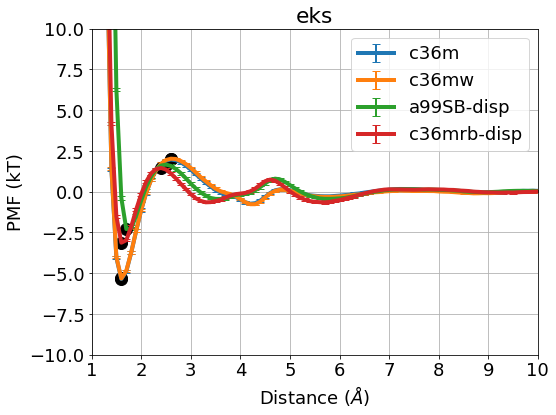

In [5]:
wdir='/home/ping/tutorial/fep/'
ncol = 1
kB = 0.593/298 # kcal/mol
T = 300
beta = 1.0/(kB*T)
ffs = ['chm36m','chm36mw','a99sbdisp',]
fflabels = ['c36m','c36mw','a99SB-disp']
ffs = ['chm36m','chm36mw','a99sbdisp','c36mrbdisp',]
fflabels = ['c36m','c36mw','a99SB-disp','c36mrb-disp',]
pdbids=['eks',]
#colors = ['r','b','g',]

i = 1
width = 2
for pdbid in pdbids:
    
    print(">> "+wdir+pdbid)

    ## plotting
    plt.figure(i)
    
    # loop force fields
    for k in range(0,len(ffs)):
        ff = ffs[k]
        dat = np.loadtxt(wdir+pdbid+'/'+ff+'/'+pdbid+'.'+ff+'.Gong2022.pmf')
        
        #plt.plot(dat[:,0], dat[:,1], colors[k], label=fflabels[k])
        plt.errorbar(dat[:,0], dat[:,1], yerr=dat[:,2], label=fflabels[k], capsize=4, elinewidth=2) #color=colors[k], 
        
        inx = signal.find_peaks(dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        plt.plot(dat[inx,0], dat[inx,1], "ko")
        
        inx = signal.find_peaks(-dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        plt.plot(dat[inx,0], dat[inx,1], "ko")
        
        # stabilities
        inx = signal.find_peaks(-dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        #print(ff+': inx_min = ', inx)
    
    # setting
    plt.xlim([1,10])
    plt.ylim([-10,10])
    #plt.yticks(np.arange(-4,3,2))
    plt.title(pdbid)
    plt.xticks(np.arange(1,11,1))
    plt.grid()
    plt.legend()
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('PMF (kT)')
    i += 1
    
    #plt.savefig(wdir+'figures/ala2.svg')

## PMF curve of all pairs

>> /home/ping/tutorial/fep/ww_p
>> /home/ping/tutorial/fep/ww_pd
>> /home/ping/tutorial/fep/ww_ap
>> /home/ping/tutorial/fep/ww_apd
>> /home/ping/tutorial/fep/ww_etf
>> /home/ping/tutorial/fep/ww_etf2
>> /home/ping/tutorial/fep/wf_etf
>> /home/ping/tutorial/fep/wf_p
>> /home/ping/tutorial/fep/wf_pd
>> /home/ping/tutorial/fep/wy_etf
>> /home/ping/tutorial/fep/wy_pd
>> /home/ping/tutorial/fep/wp_p
>> /home/ping/tutorial/fep/wp_pd
>> /home/ping/tutorial/fep/wp_pda
>> /home/ping/tutorial/fep/ff_etf
>> /home/ping/tutorial/fep/ff_ap
>> /home/ping/tutorial/fep/ff_apd
>> /home/ping/tutorial/fep/fa_pd
>> /home/ping/tutorial/fep/fl_p
>> /home/ping/tutorial/fep/fl_pd
>> /home/ping/tutorial/fep/wl_pd
>> /home/ping/tutorial/fep/wl_pd2
>> /home/ping/tutorial/fep/wl_pd3
>> /home/ping/tutorial/fep/wa_pd
>> /home/ping/tutorial/fep/aa_h
>> /home/ping/tutorial/fep/la_s
>> /home/ping/tutorial/fep/la_h
>> /home/ping/tutorial/fep/ll_p
>> /home/ping/tutorial/fep/bk
>> /home/ping/tutorial/fep/br
>> /home/ping

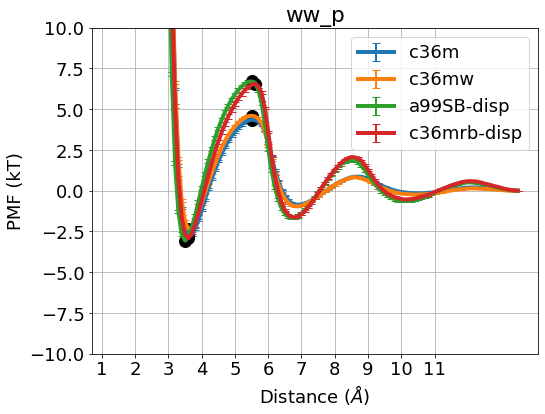

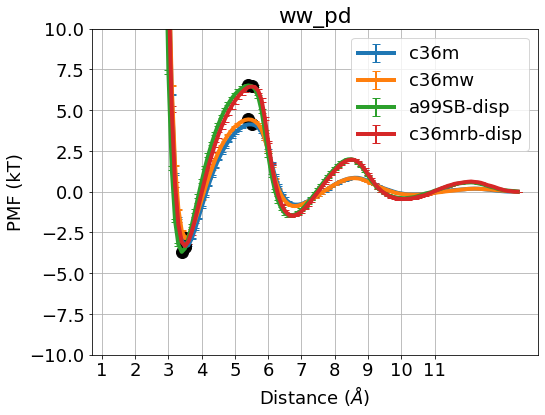

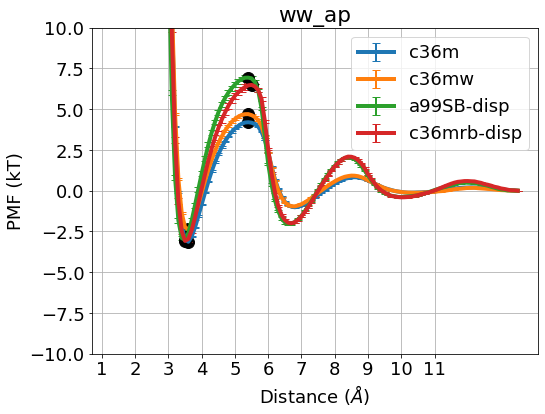

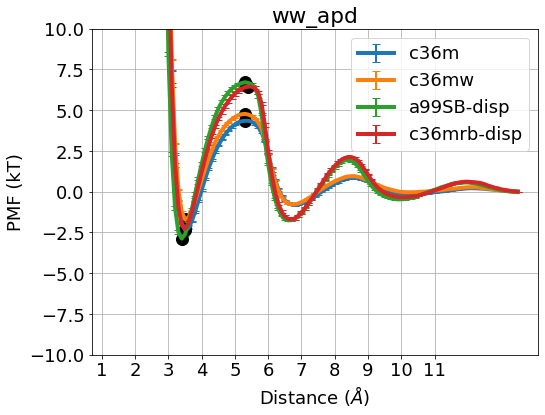

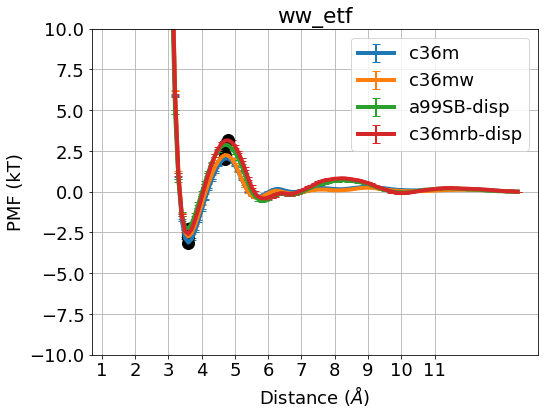

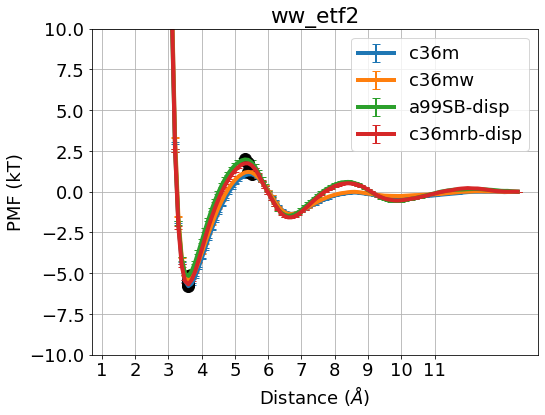

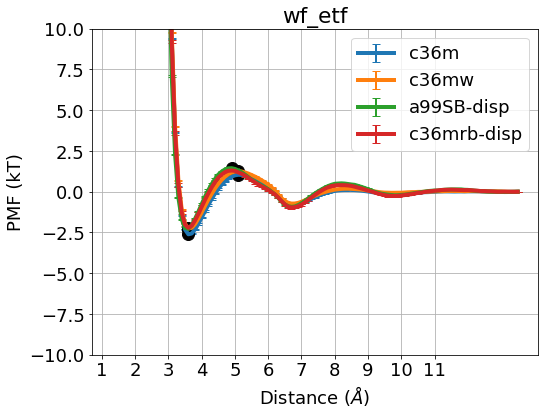

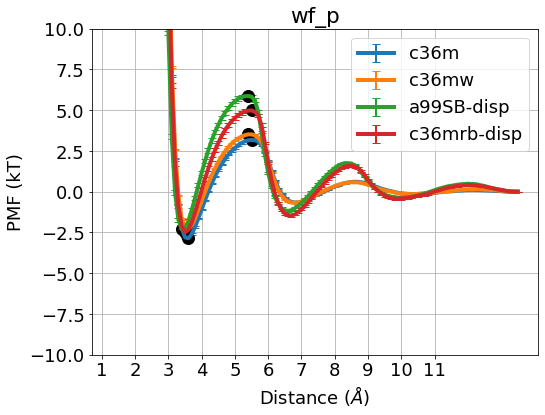

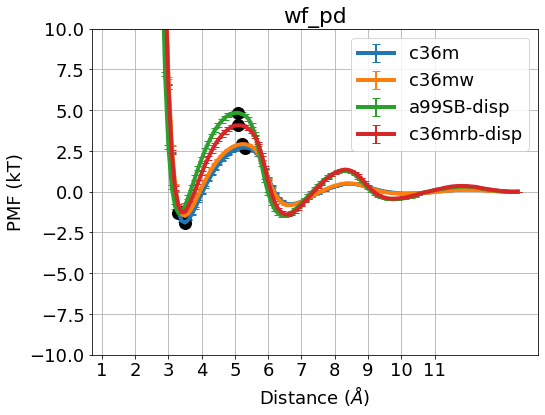

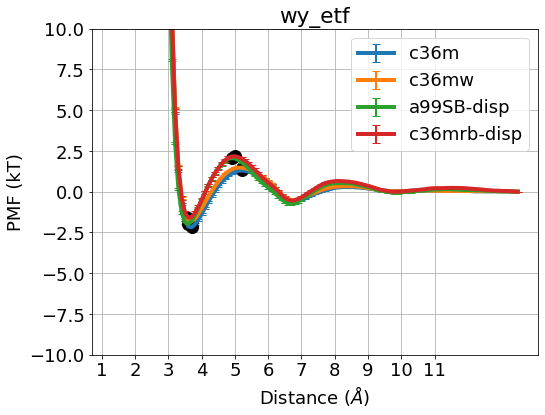

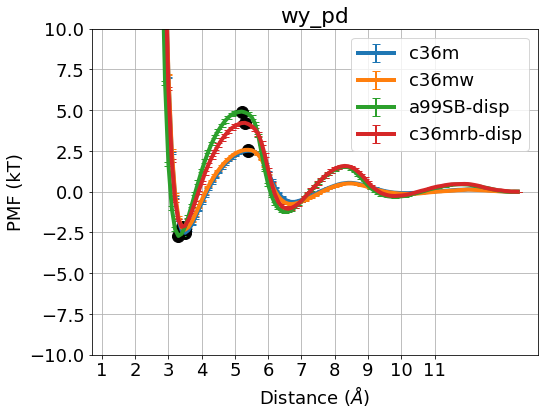

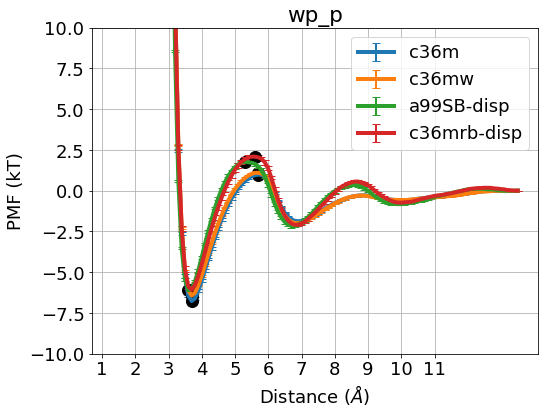

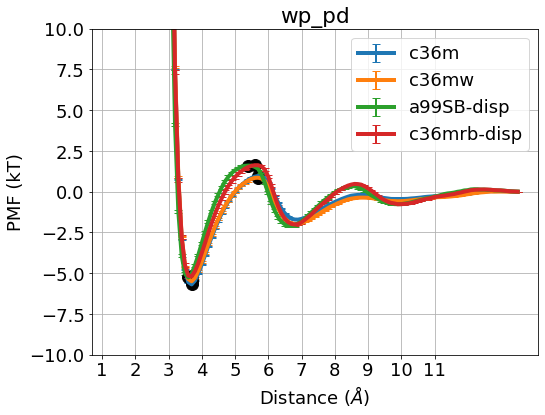

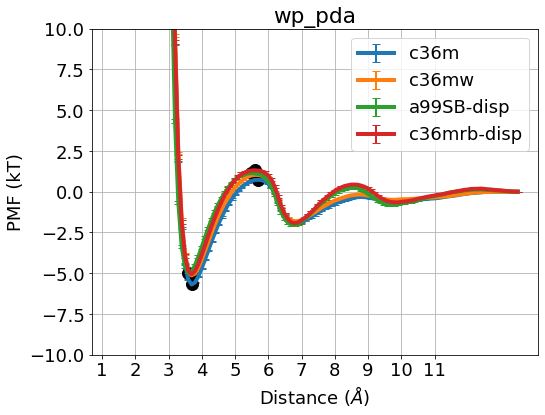

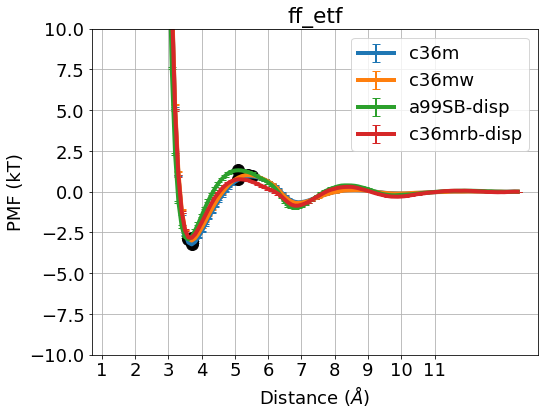

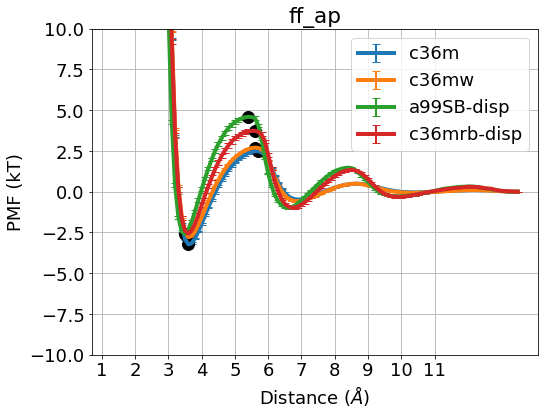

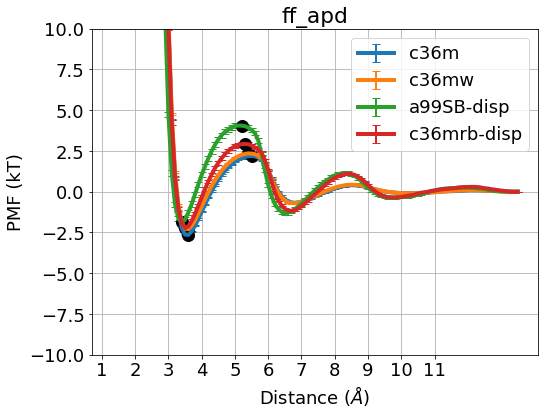

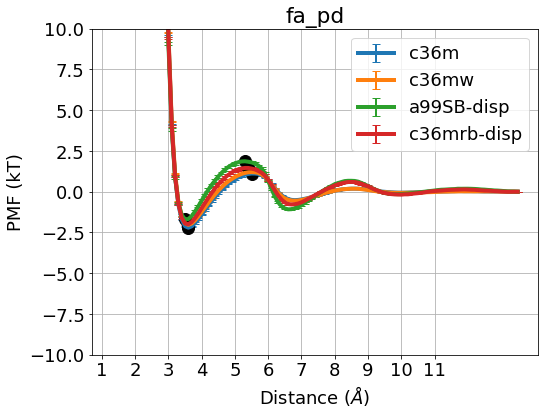

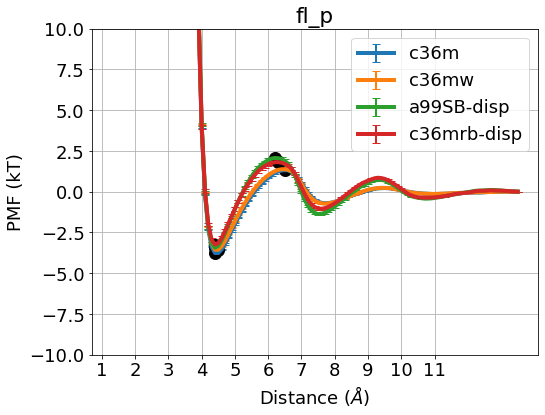

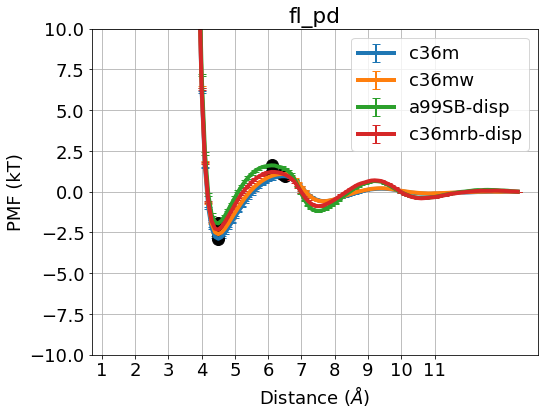

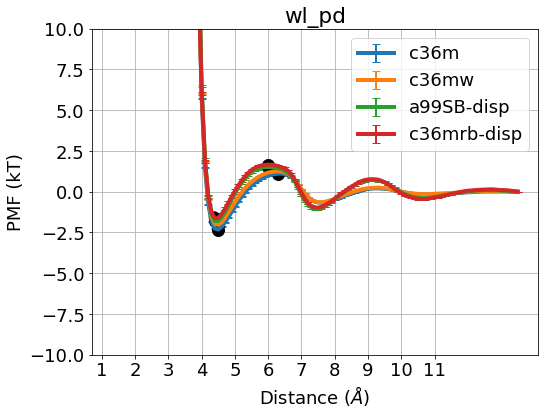

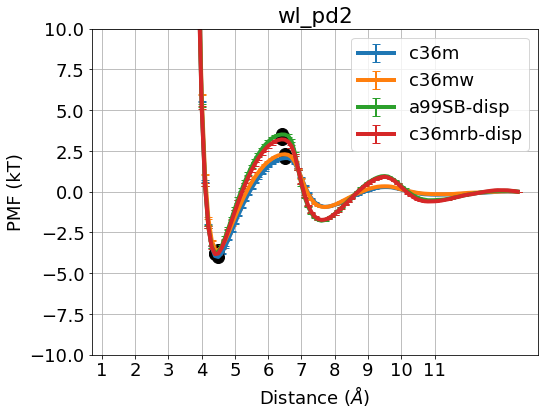

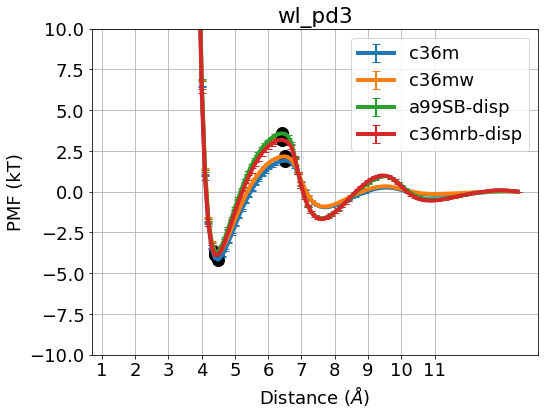

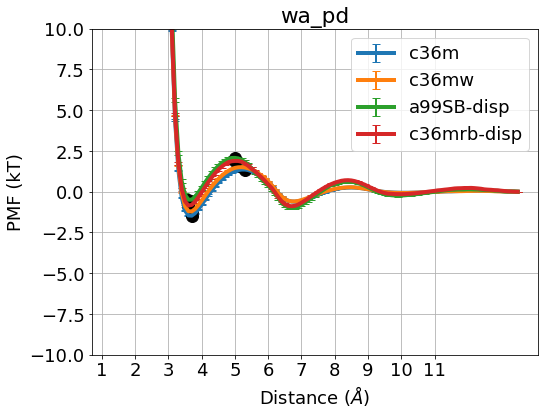

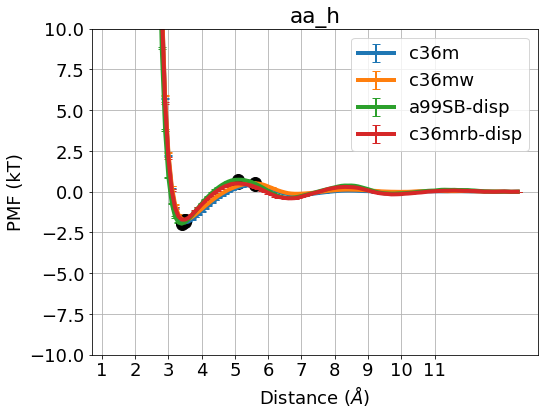

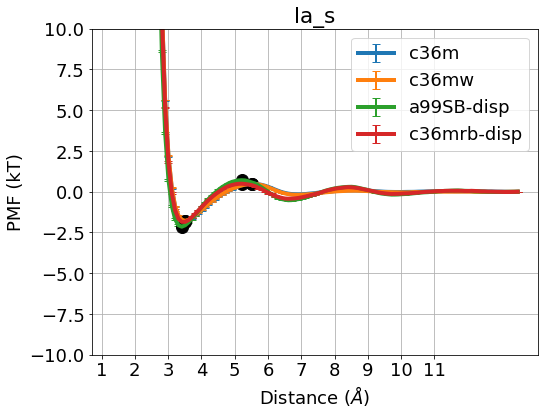

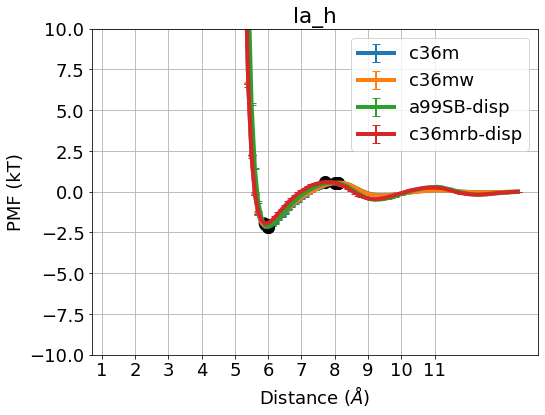

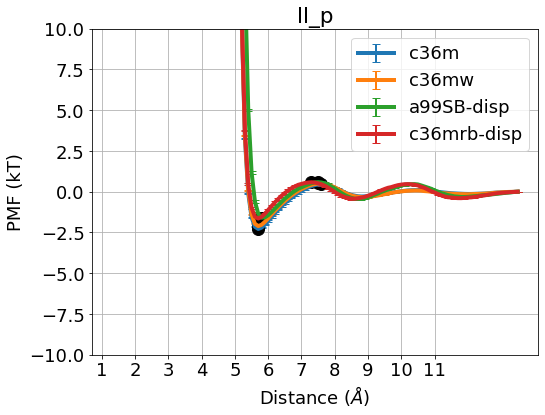

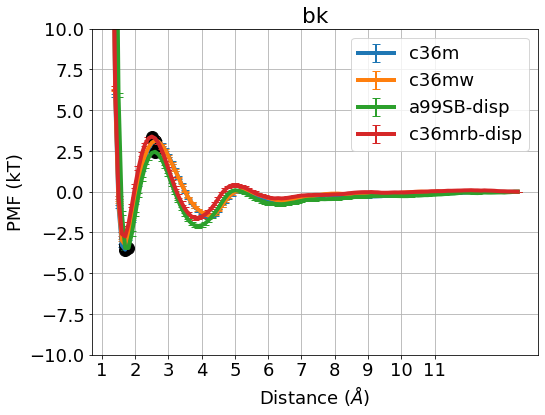

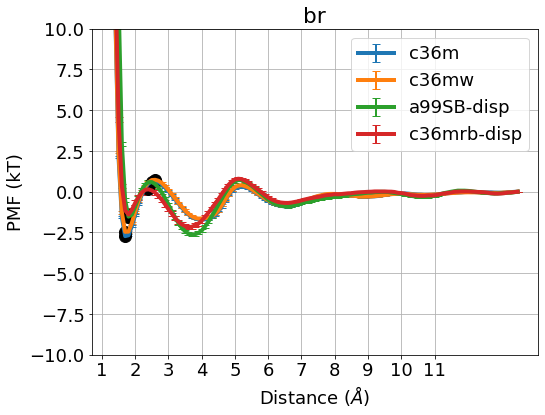

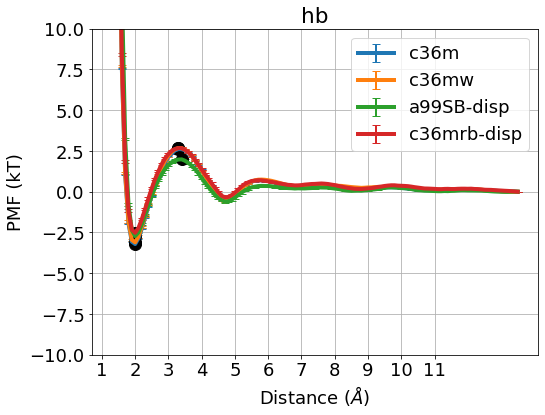

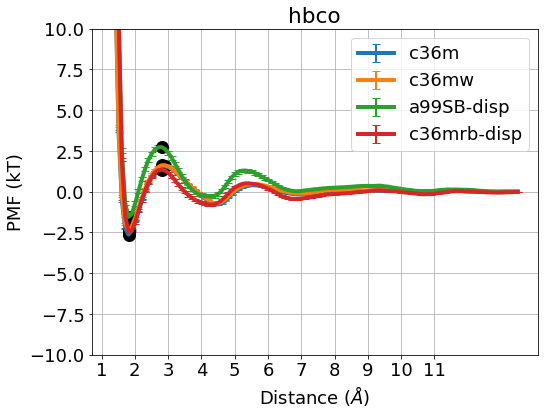

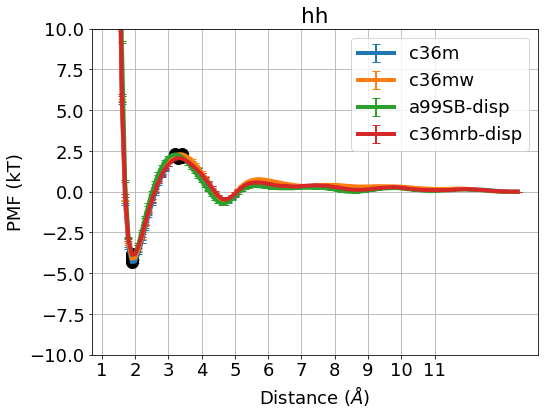

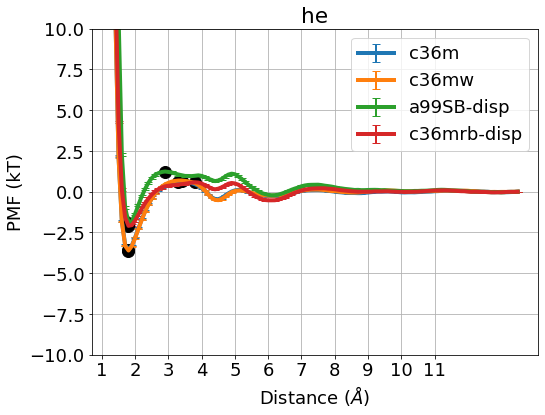

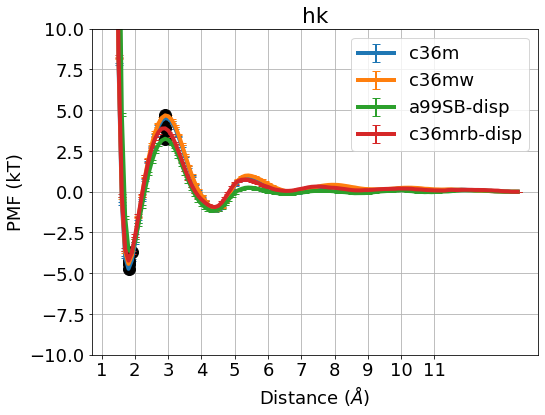

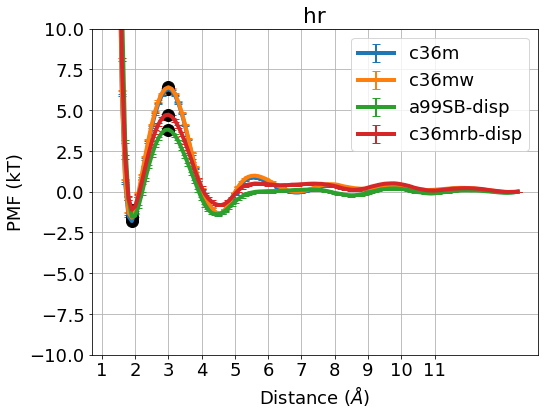

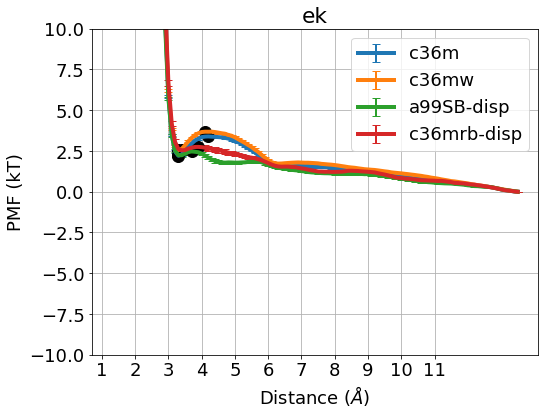

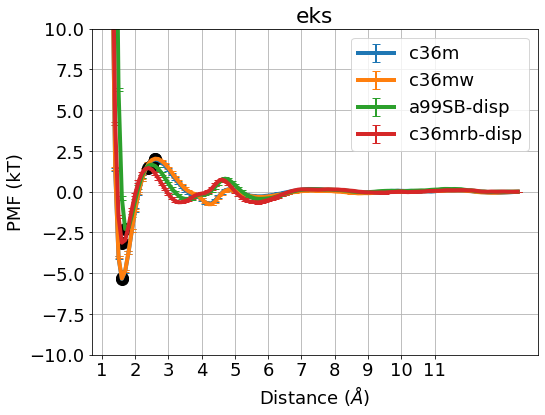

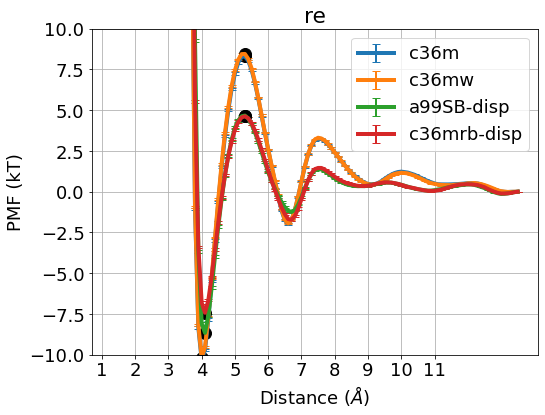

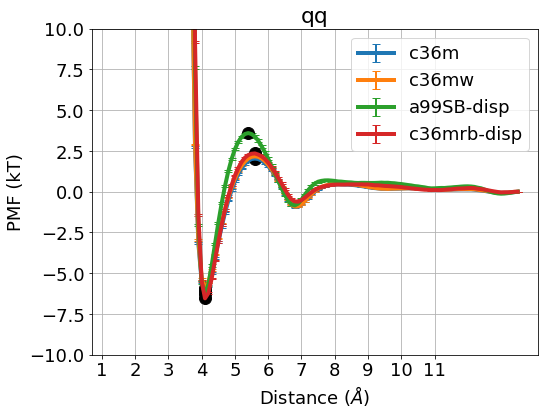

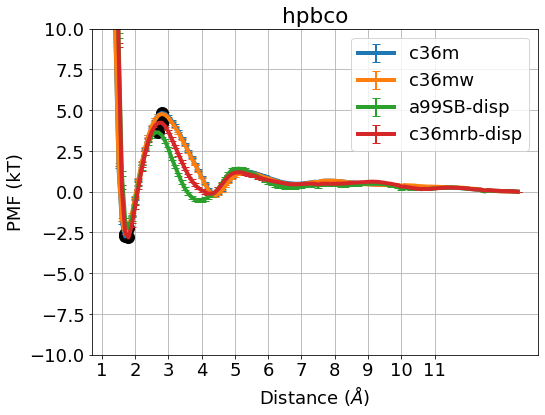

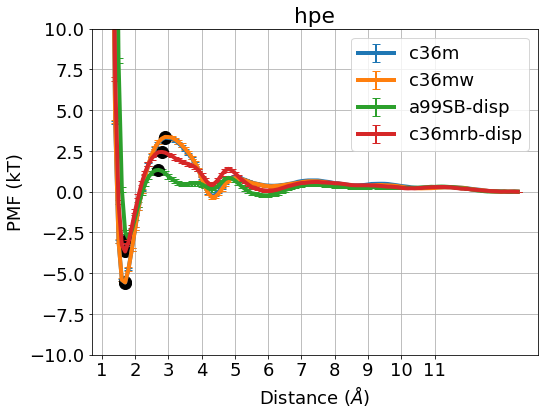

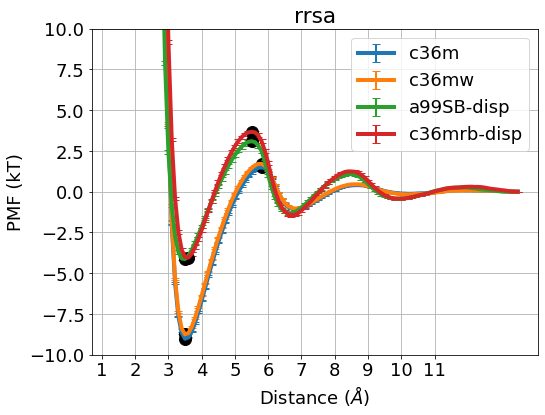

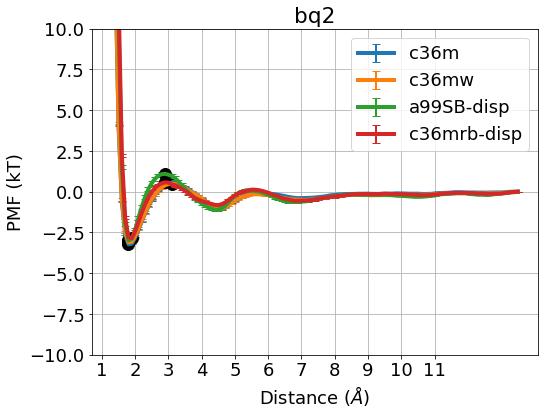

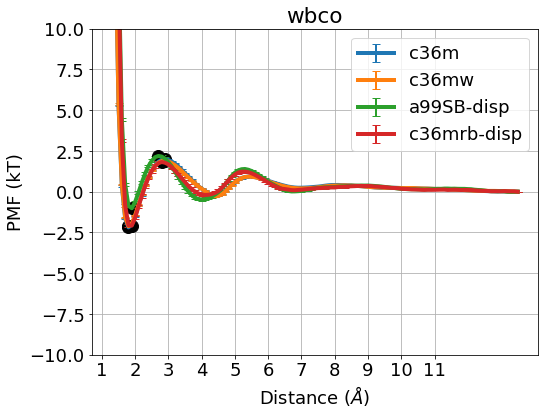

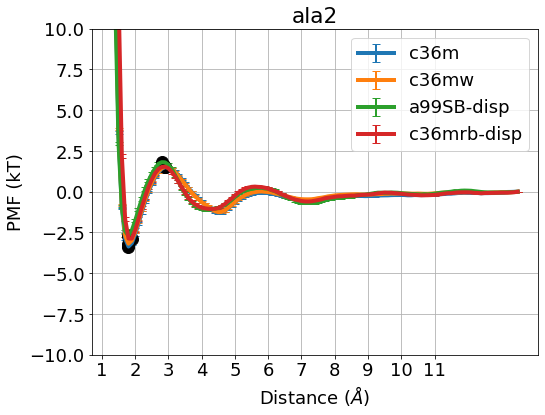

In [6]:
wdir='/home/ping/tutorial/fep/'
ncol = 1
kB = 0.593/298 # kcal/mol
T = 300
beta = 1.0/(kB*T)
ffs = ['chm36m','chm36mw','a99sbdisp',]
fflabels = ['c36m','c36mw','a99SB-disp']
ffs = ['chm36m','chm36mw','a99sbdisp','c36mrbdisp',]
fflabels = ['c36m','c36mw','a99SB-disp','c36mrb-disp',]
pdbids=['ww_p','ww_pd','ww_ap','ww_apd','ww_etf','ww_etf2',
        'wf_etf','wf_p','wf_pd',
        'wy_etf','wy_pd',
        'wp_p','wp_pd','wp_pda',
        'ff_etf','ff_ap','ff_apd',
        'fa_pd','fl_p','fl_pd','wl_pd','wl_pd2','wl_pd3','wa_pd',
        'aa_h','la_s','la_h','ll_p',
        'bk','br','hb','hbco',
        'hh','he','hk','hr','ek','eks','re','qq','hpbco',
        'hpe','rrsa','bq2','wbco','ala2',
       ]
#colors = ['r','b','g',]

i = 1
width = 2
for pdbid in pdbids:
    
    print(">> "+wdir+pdbid)

    ## plotting
    plt.figure(i)
    
    # loop force fields
    for k in range(0,len(ffs)):
        ff = ffs[k]
        dat = np.loadtxt(wdir+pdbid+'/'+ff+'/'+pdbid+'.'+ff+'.Gong2022.pmf')
        
        #plt.plot(dat[:,0], dat[:,1], colors[k], label=fflabels[k])
        plt.errorbar(dat[:,0], dat[:,1], yerr=dat[:,2], label=fflabels[k], capsize=4, elinewidth=2) #color=colors[k], 
        
        inx = signal.find_peaks(dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        plt.plot(dat[inx,0], dat[inx,1], "ko")
        
        inx = signal.find_peaks(-dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        plt.plot(dat[inx,0], dat[inx,1], "ko")
        
        # stabilities
        inx = signal.find_peaks(-dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        #print(ff+': inx_min = ', inx)
    
    # setting
    plt.ylim([-10,10])
    #plt.yticks(np.arange(-4,3,2))
    plt.title(pdbid)
    plt.xticks(np.arange(1,12,1))
    plt.grid()
    plt.legend()
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('PMF (kT)')
    i += 1
    
    #plt.savefig(wdir+'figures/ala2.svg')

## Stabilities

The stability can be defined as the difference between the first valley and the average value of all PMF data more than 1.1 nm.

$\text{Stability} = \text{Mean}[G(\xi > 1.1 nm)] - G(\xi = \text{first min})$.

The following results showed that 

1) The stabilities calculated from c36m are mostly larger than those calculated from a99sb-disp force field. This seems consistent with one observation that a99SB-disp force field is less compact.

2) There are larger difference in the polar sidechain pairs than nonpolar pairs, which could be mainly due to the different interactions between sidechain-water models (TIP3P vs. TIP4PD), in particular for some charged residues, such as Arg or Glu-involved pairs (he, eks, hpe, and rrsa). These sidechain pairs favor the TIP4PD water more than TIP3P water. This will reduce their stabilities of sidechain pairs.

0 ww_p stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [3.10877745 2.79830714 2.30360966 3.00693219]
1 ww_pd stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [3.83747903 3.3900028  2.85328433 3.48063166]
2 ww_ap stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [3.14065368 3.17719078 2.39459963 3.22970117]
3 ww_apd stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [3.02757182 2.39646398 1.79799343 2.44771356]
4 ww_etf stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [2.35230923 3.21838926 2.81505825 2.69068574]
5 ww_etf2 stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [5.13633973 5.67454639 5.3702669  5.65251452]
6 wf_etf stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [2.29420321 2.60113296 2.27169872 2.22851508]
7 wf_p stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [2.4278339  2.84919871 2.32868934 2.57357884]
8 wf_pd stability (kT): a99SB-disp,c36m,c36mw,c36mrb-disp =  [1.36960752 1.91483899 1.5026086  1.34846196]
9 wy_etf stability (kT): a99SB-dis

<Figure size 1440x432 with 0 Axes>

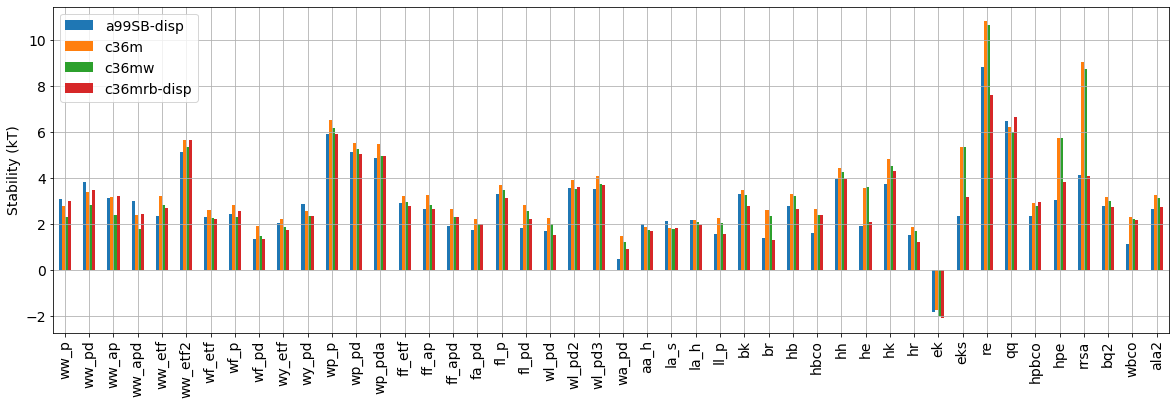

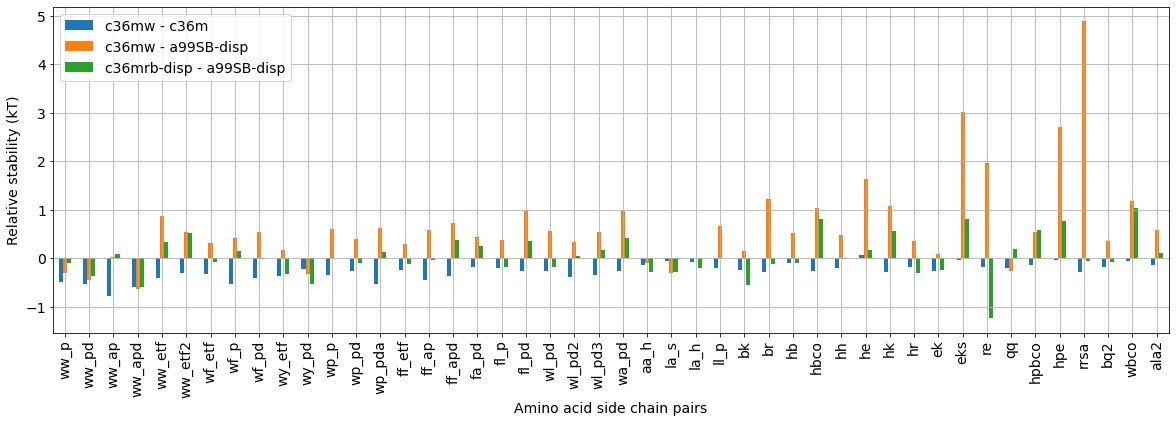

In [8]:
wdir='/home/ping/tutorial/fep/'

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
plt.rcParams['figure.figsize'] = [20, 6]
plt.rcParams.update({'font.size': 14})

ffs = ['a99sbdisp','chm36m','chm36mw','c36mrbdisp']
fflabels = ['a99SB-disp','c36m','c36mw','c36mrb-disp']
#colors = ['r','b','g',]
pdbids=['ww_p','ww_pd','ww_ap','ww_apd','ww_etf','ww_etf2',
        'wf_etf','wf_p','wf_pd',
        'wy_etf','wy_pd',
        'wp_p','wp_pd','wp_pda',
        'ff_etf','ff_ap','ff_apd',
        'fa_pd','fl_p','fl_pd','wl_pd','wl_pd2','wl_pd3','wa_pd',
        'aa_h','la_s','la_h','ll_p',
        'bk','br','hb','hbco',
        'hh','he','hk','hr','ek','eks','re','qq','hpbco',
        'hpe','rrsa','bq2','wbco','ala2',
       ]

stability = np.zeros((len(pdbids),len(ffs)))
dist = 10
i = 0
for pdbid in pdbids:
    k = 0
    for ff in ffs:
        dat = np.loadtxt(wdir+pdbid+'/'+ff+'/'+pdbid+'.'+ff+'.Gong2022.pmf')
        inx = signal.find_peaks(-dat[:,1])[0]
        inx = inx[np.where(dat[inx,1]<10)][-1]
        iny = np.where(dat[:,0]>dist)
        stability[i,k] = np.mean(dat[iny,1]) - dat[inx,1]
        k += 1
    if len(ffs)==3: print(i, pdbid, 'stability (kT): '+fflabels[0]+','+fflabels[1]+','+fflabels[2]+' = ', stability[i,:])
    if len(ffs)==4: print(i, pdbid, 'stability (kT): '+fflabels[0]+','+fflabels[1]+','+fflabels[2]+','+fflabels[3]+' = ', stability[i,:])
    i += 1
    
# plot stability
plt.figure(1)
if len(ffs)==3:
    df = pd.DataFrame({fflabels[0]: stability[:,0], fflabels[1]: stability[:,1], 
                       fflabels[2]: stability[:,2],}, index=pdbids)
if len(ffs)==4:
    df = pd.DataFrame({fflabels[0]: stability[:,0], fflabels[1]: stability[:,1], 
                       fflabels[2]: stability[:,2], fflabels[3]: stability[:,3]}, index=pdbids)
ax = df.plot.bar()
plt.ylabel('Stability (kT)')
plt.grid()
#plt.xticks([])

plt.figure(2)
if len(ffs)==3:
    df = pd.DataFrame({'c36mw - c36m': stability[:,2]-stability[:,1], 
                       'c36mw - a99SB-disp': stability[:,1]-stability[:,0]},index=pdbids)
if len(ffs)==4:
    df = pd.DataFrame({'c36mw - c36m': stability[:,2]-stability[:,1], 
                       'c36mw - a99SB-disp': stability[:,1]-stability[:,0], 
                       'c36mrb-disp - a99SB-disp': stability[:,3]-stability[:,0]},index=pdbids)

ax = df.plot.bar()
plt.ylabel('Relative stability (kT)')
plt.xlabel('Amino acid side chain pairs')
plt.grid()

kB = 0.593/298 # kcal/mol
inx0 = [0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
inx1 = [9,19,29,30,31,32,41,44,45,]
inx2 = [33,34,35,36,37,38,39,40,42,43,]
#inx3 = [33,36,37,38,42]
inx3 = [42,]
print('nonpolar pairs = ', np.mean(stability[inx0,0] - stability[inx0,2]) * kB*300)
print('polar pairs = ', np.mean(stability[inx1,0] - stability[inx1,2]) * kB*300)
print('charged pairs = ', np.mean(stability[inx2,0] - stability[inx2,2]) * kB*300)
print('Glus/Args-charged pairs = ', np.mean(stability[inx3,0] - stability[inx3,2]) * kB*300)

## Free energy decomposition

After using a simple approximation (please see the appendix), we can readily do the free energy decomposition by dividing the $f_{ab} (x)$ into different reduced energy components, for example, 

$f_{ab}(x) = f_{ab}^{rep}(x) + f_{ab}^{disp}(x) + f_{ab}^{elec}(x)$,

then, we can obtain the coresponding free energy difference,
$F_{ab}^{rep} = F_{ab}^{cav}(x)$, $F_{ab}^{dis}(x)$, and $F_{ab}^{ele}(x)$.

len(pdbids) =  46
>> /home/ping/tutorial/fep/ww_p
>> /home/ping/tutorial/fep/ww_pd
>> /home/ping/tutorial/fep/ww_ap
>> /home/ping/tutorial/fep/ww_apd
>> /home/ping/tutorial/fep/ww_etf
>> /home/ping/tutorial/fep/ww_etf2
>> /home/ping/tutorial/fep/wf_etf
>> /home/ping/tutorial/fep/wf_p
>> /home/ping/tutorial/fep/wf_pd
>> /home/ping/tutorial/fep/wy_etf
>> /home/ping/tutorial/fep/wy_pd
>> /home/ping/tutorial/fep/wp_p
>> /home/ping/tutorial/fep/wp_pd
>> /home/ping/tutorial/fep/wp_pda
>> /home/ping/tutorial/fep/ff_etf
>> /home/ping/tutorial/fep/ff_ap
>> /home/ping/tutorial/fep/ff_apd
>> /home/ping/tutorial/fep/fa_pd
>> /home/ping/tutorial/fep/fl_p
>> /home/ping/tutorial/fep/fl_pd
>> /home/ping/tutorial/fep/wl_pd
>> /home/ping/tutorial/fep/wl_pd2
>> /home/ping/tutorial/fep/wl_pd3
>> /home/ping/tutorial/fep/wa_pd
>> /home/ping/tutorial/fep/aa_h
>> /home/ping/tutorial/fep/la_s
>> /home/ping/tutorial/fep/la_h
>> /home/ping/tutorial/fep/ll_p
>> /home/ping/tutorial/fep/bk
>> /home/ping/tutorial/fe

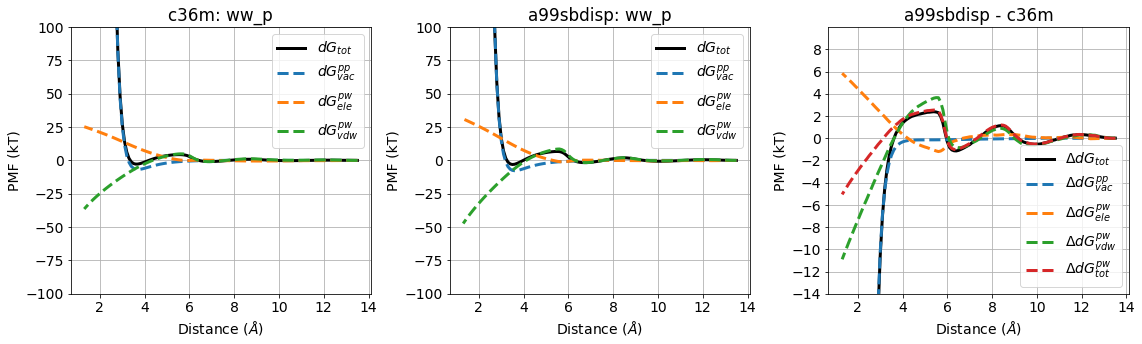

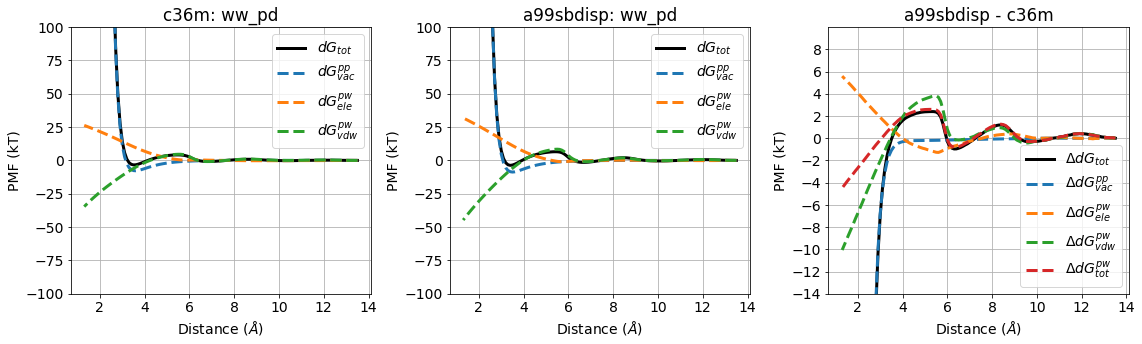

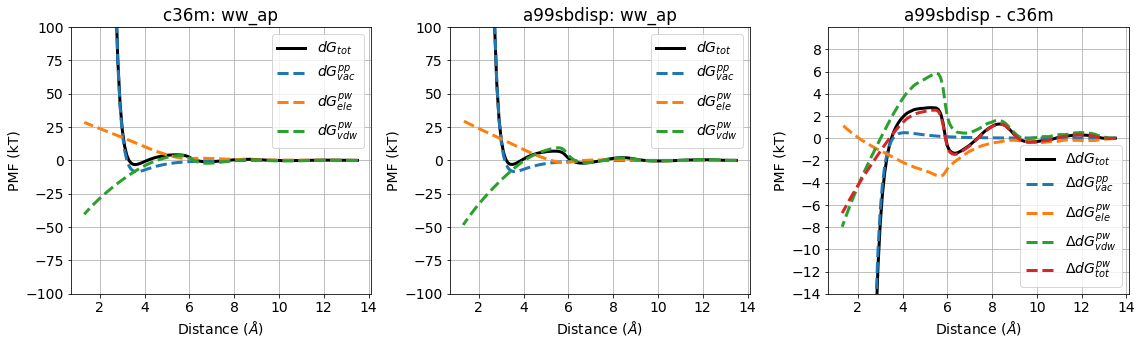

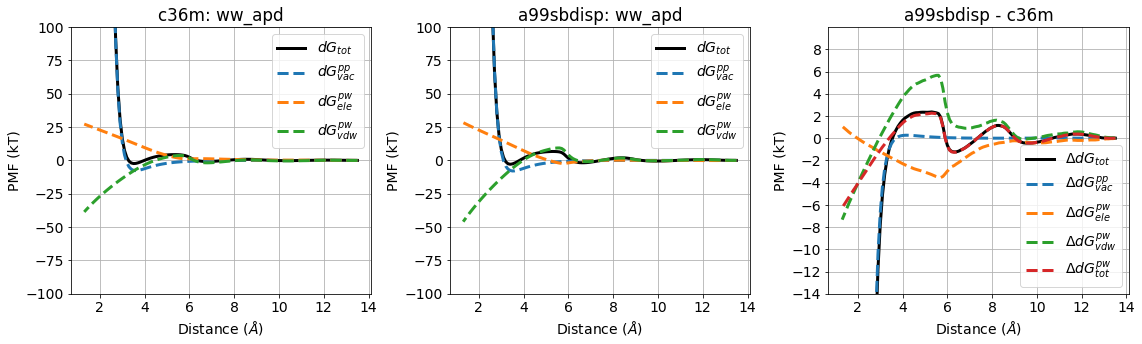

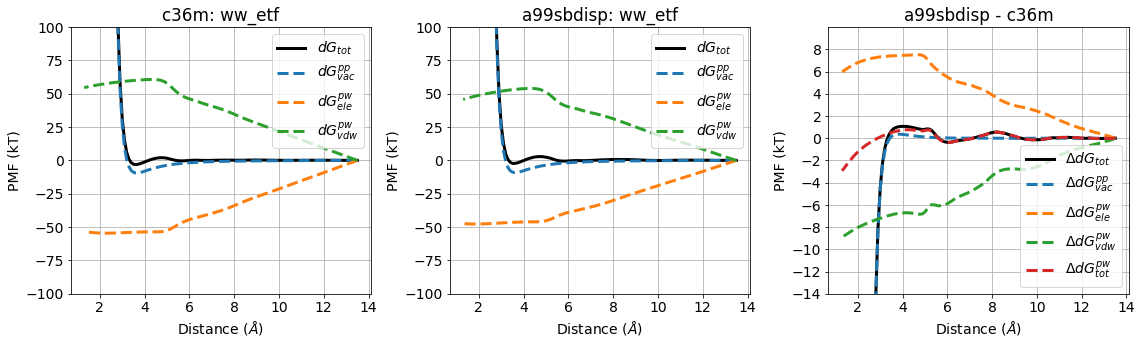

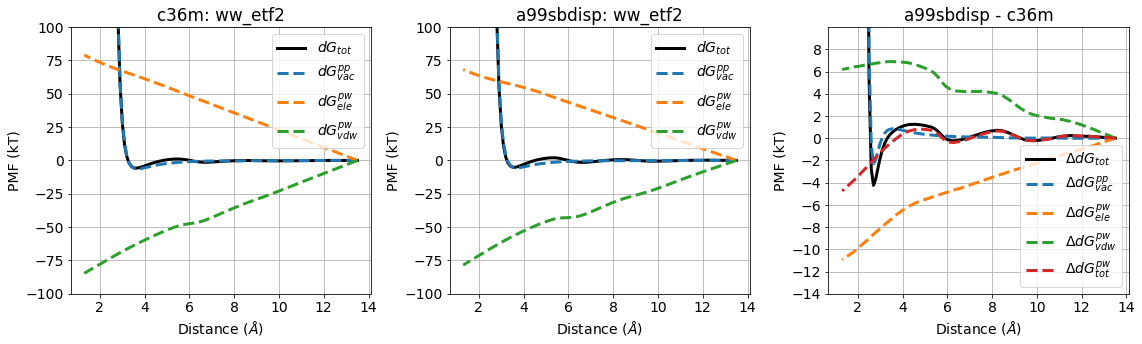

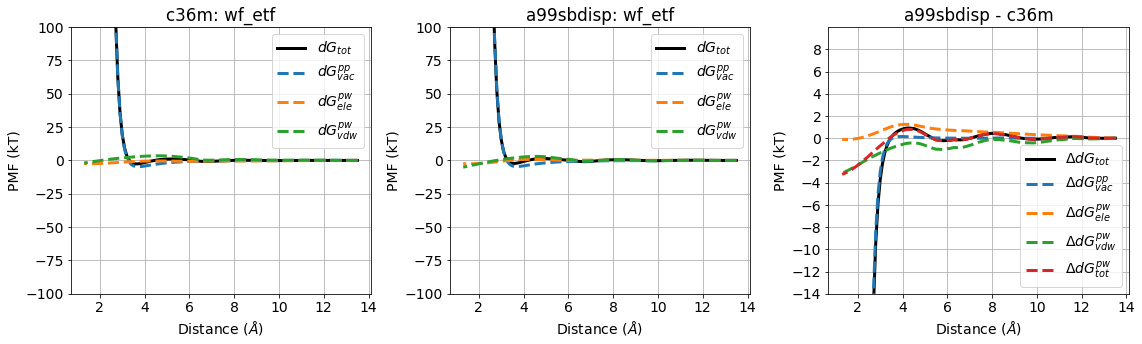

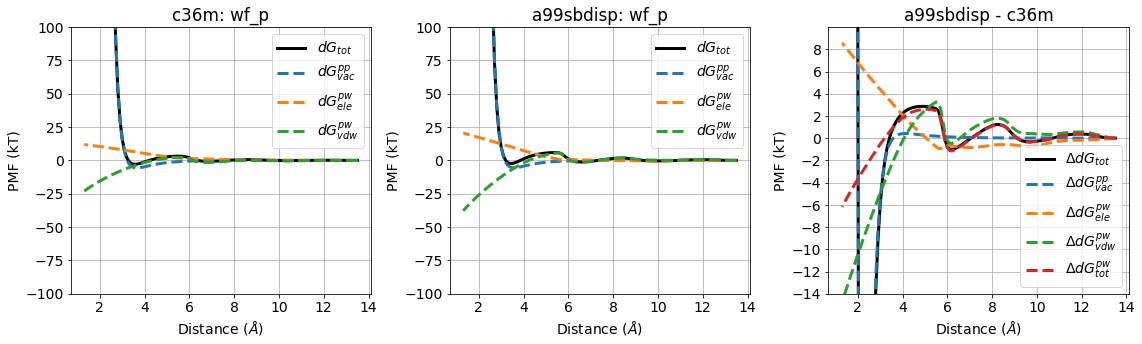

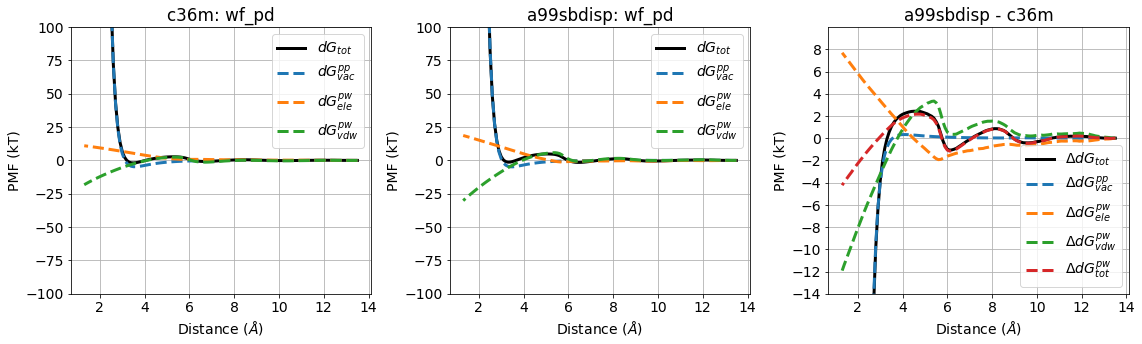

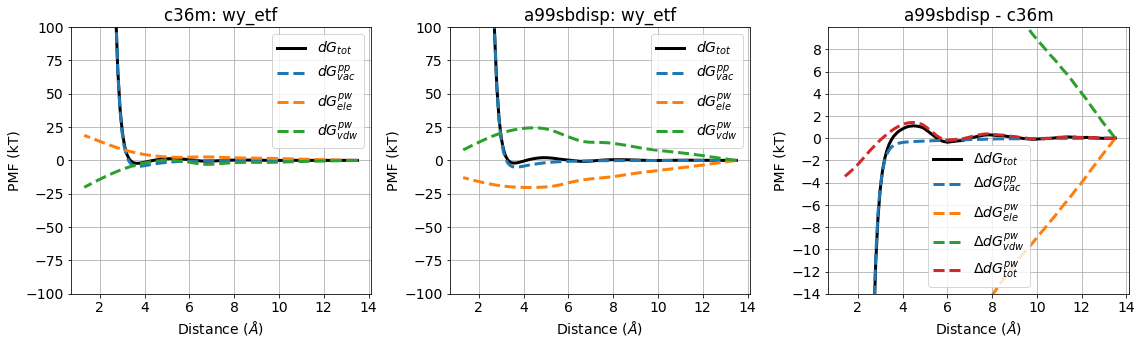

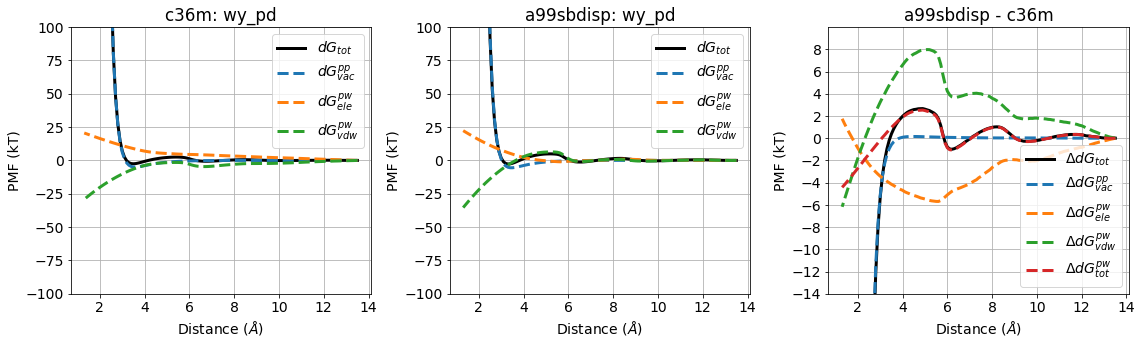

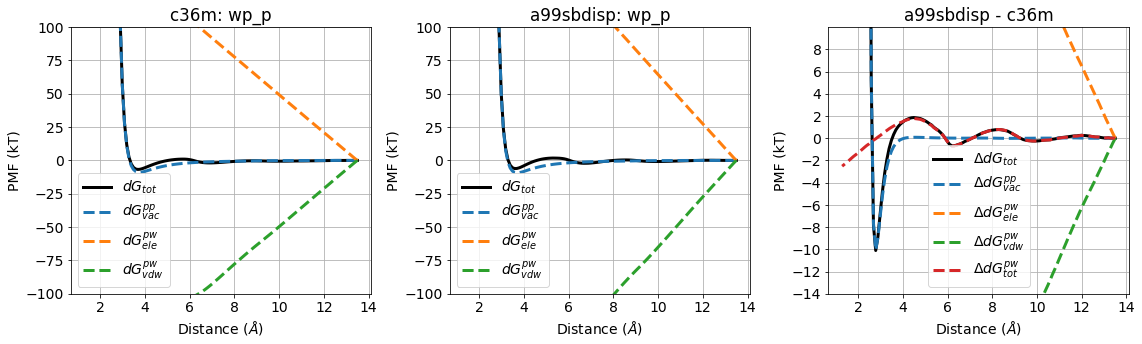

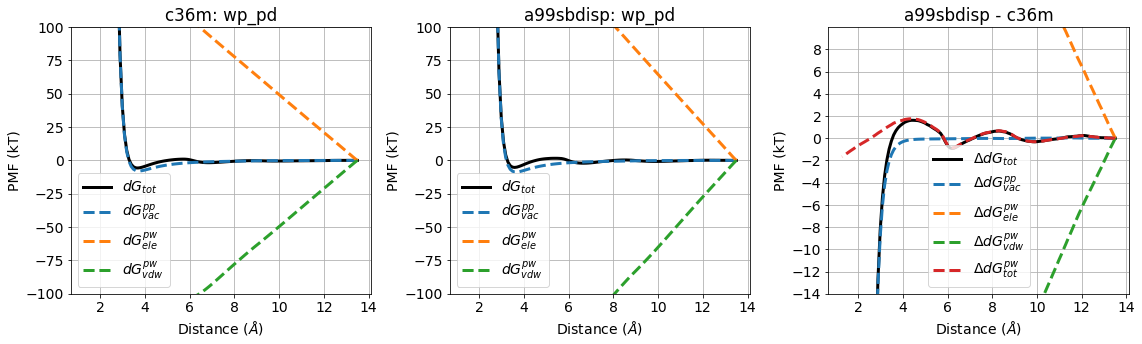

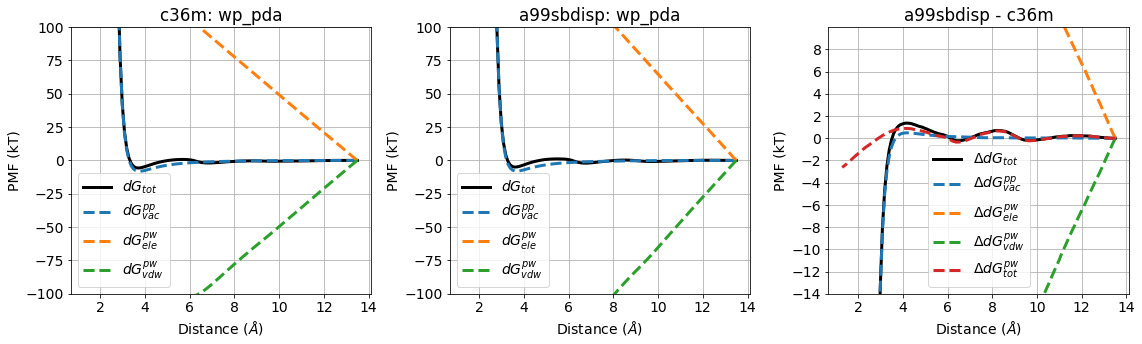

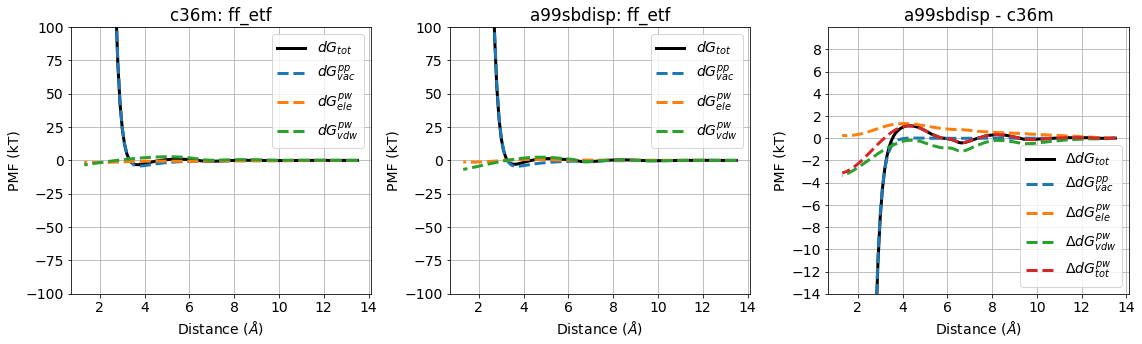

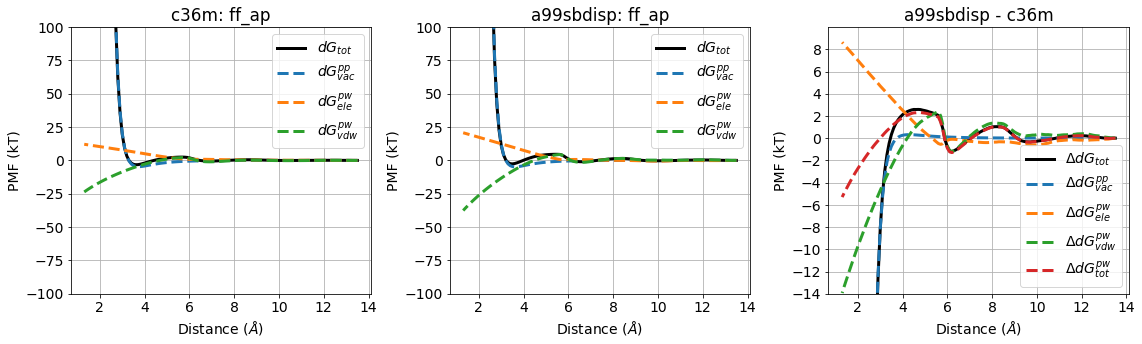

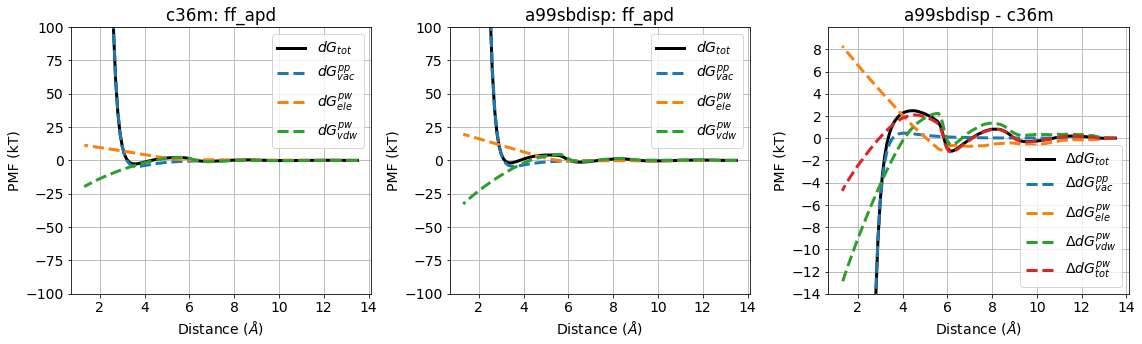

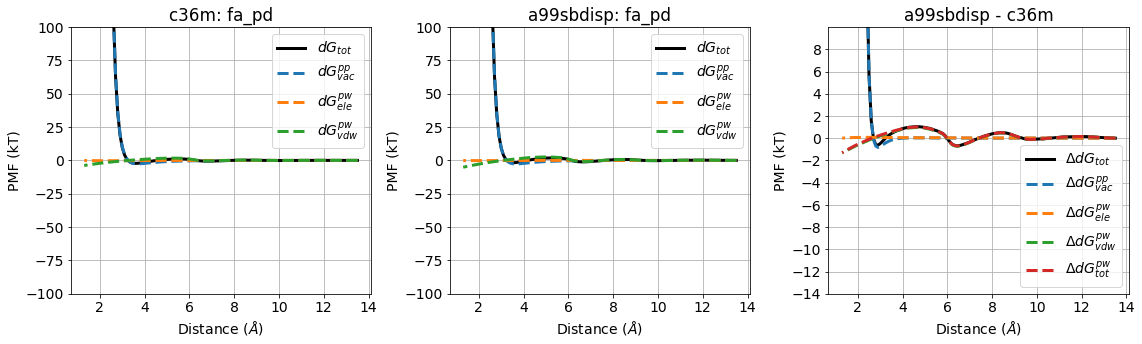

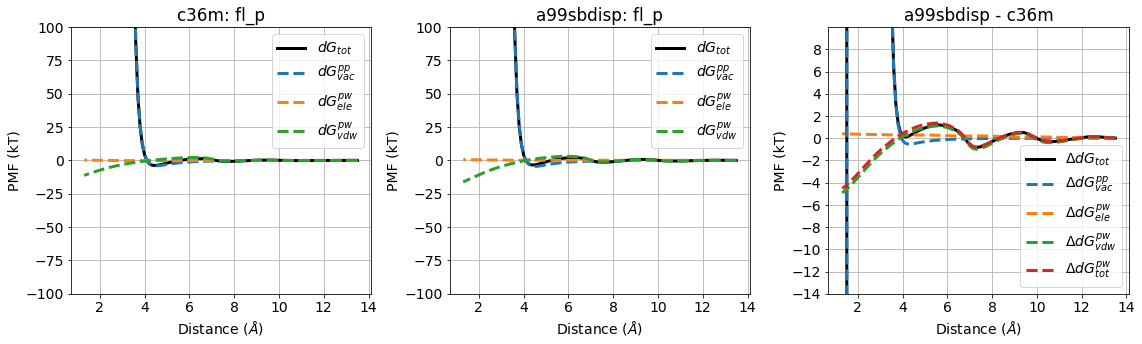

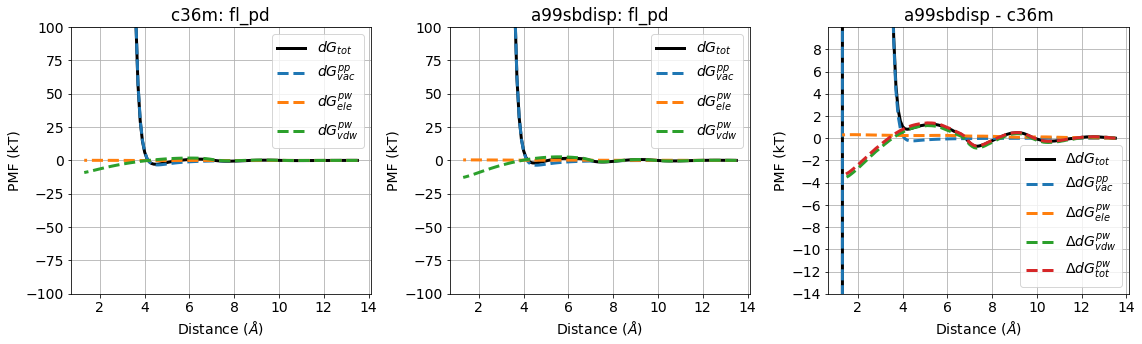

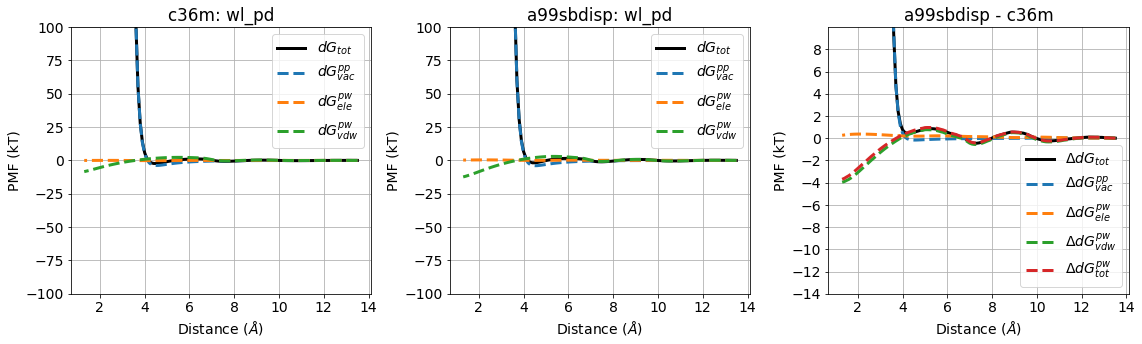

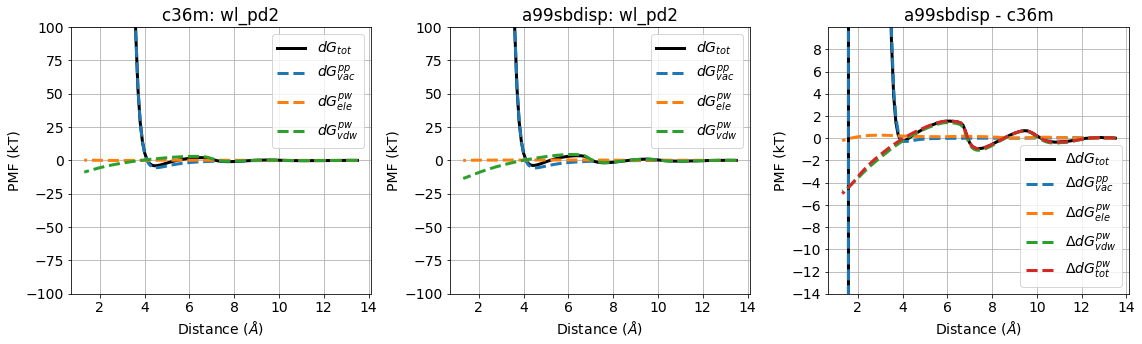

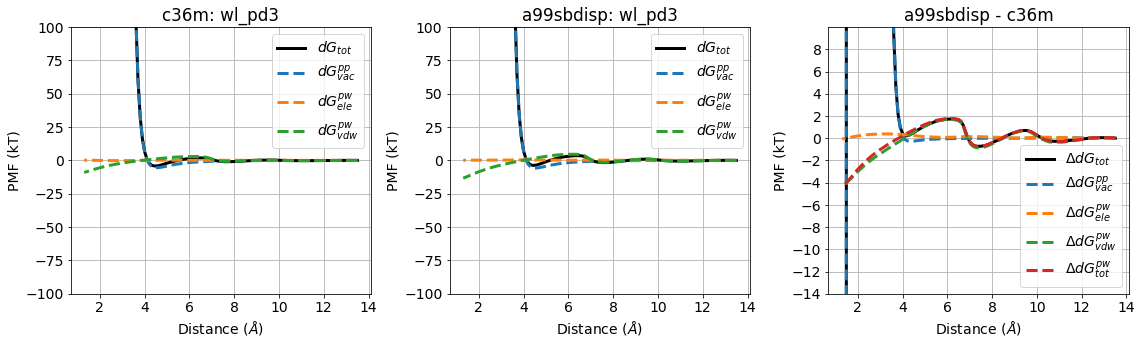

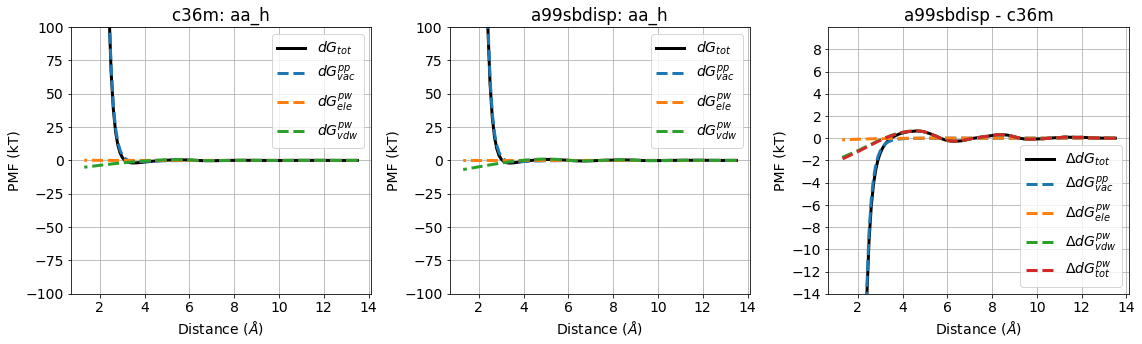

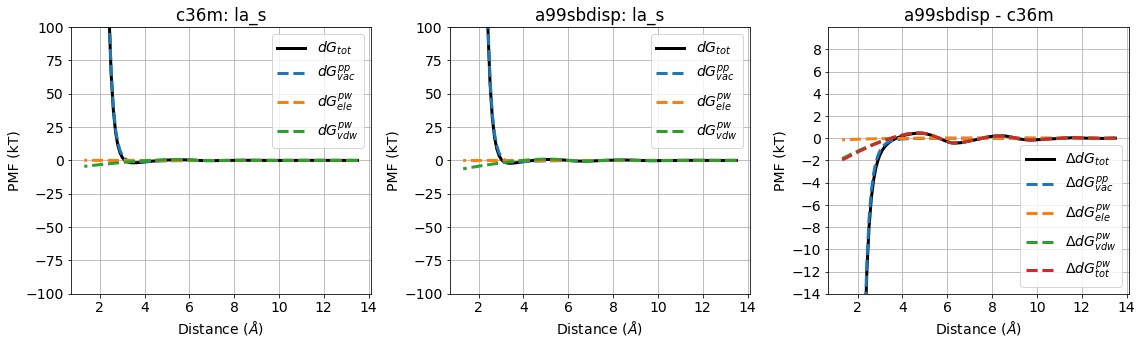

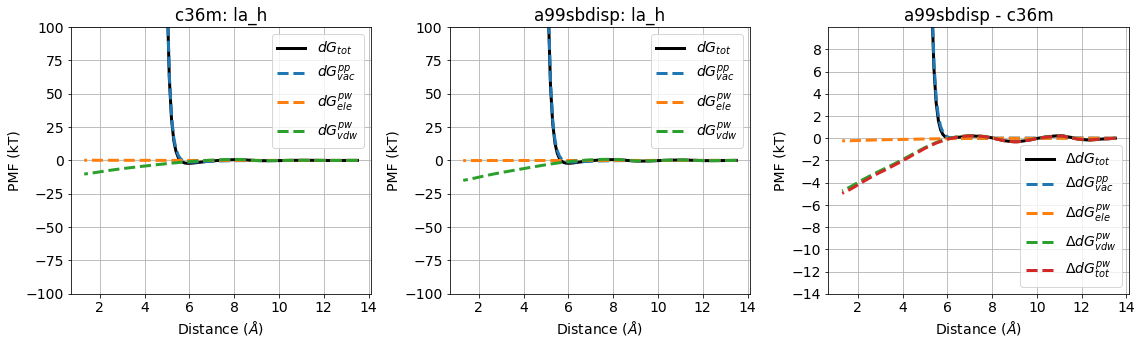

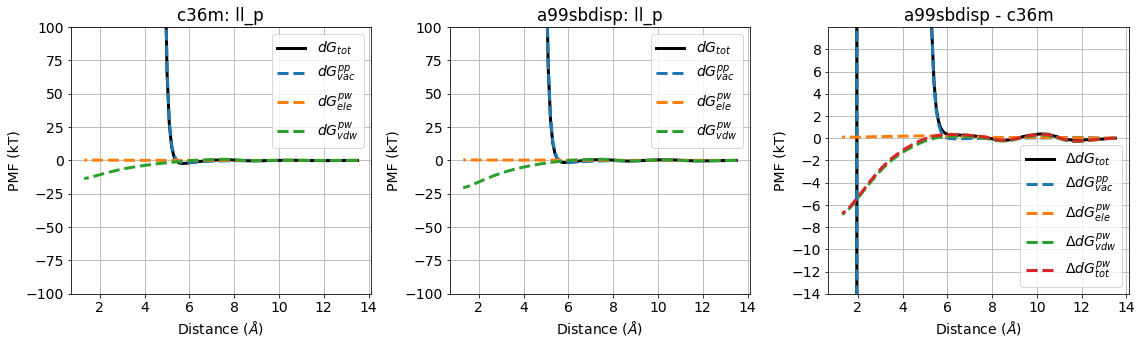

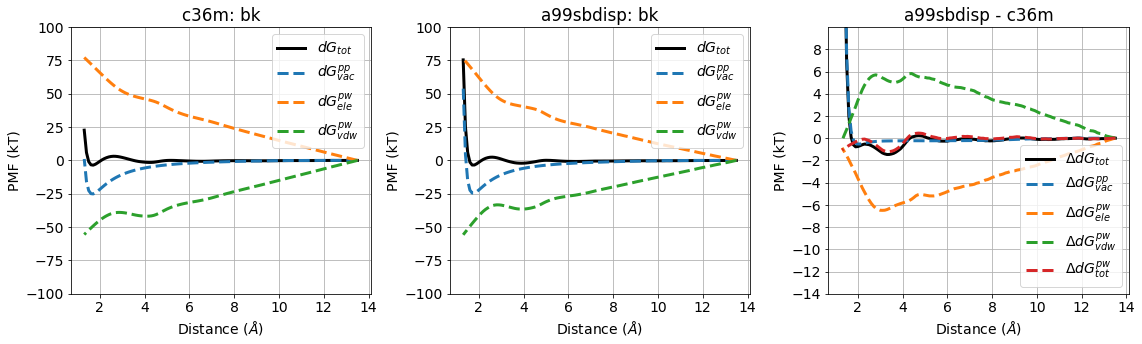

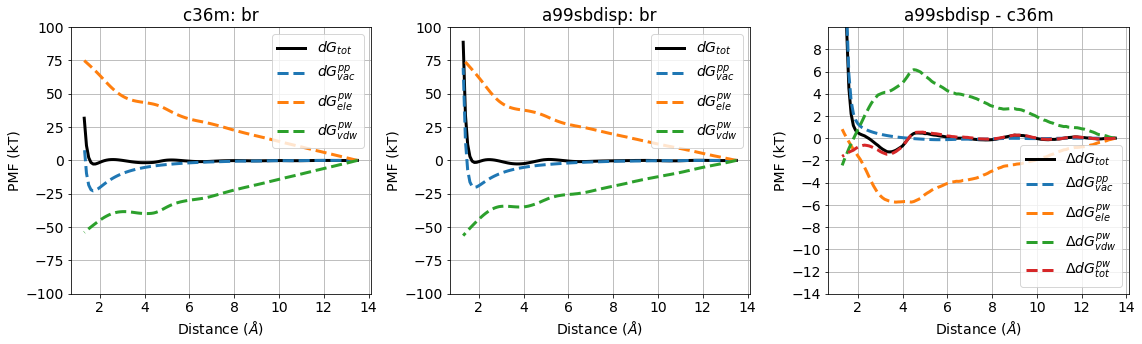

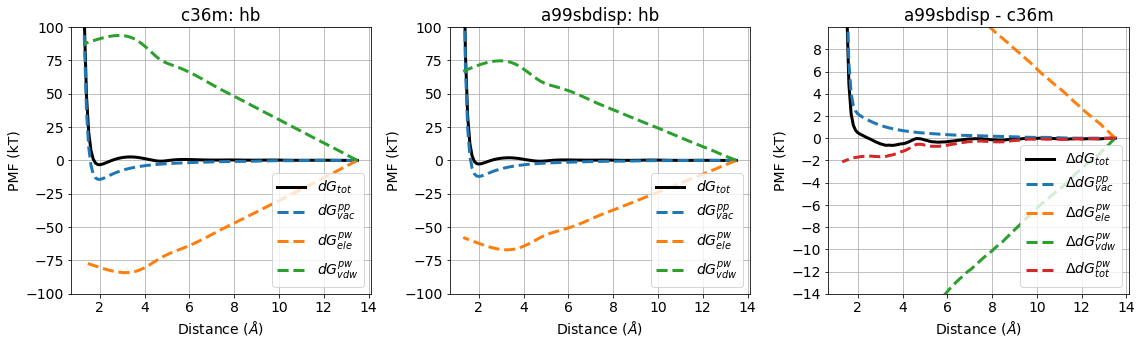

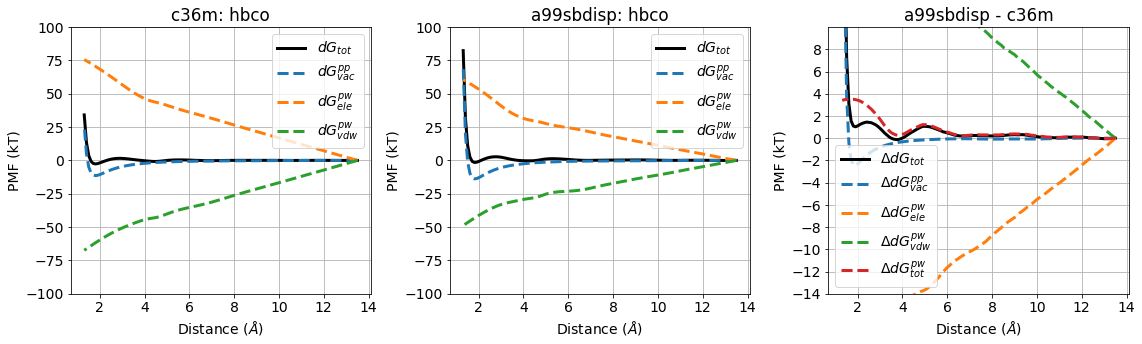

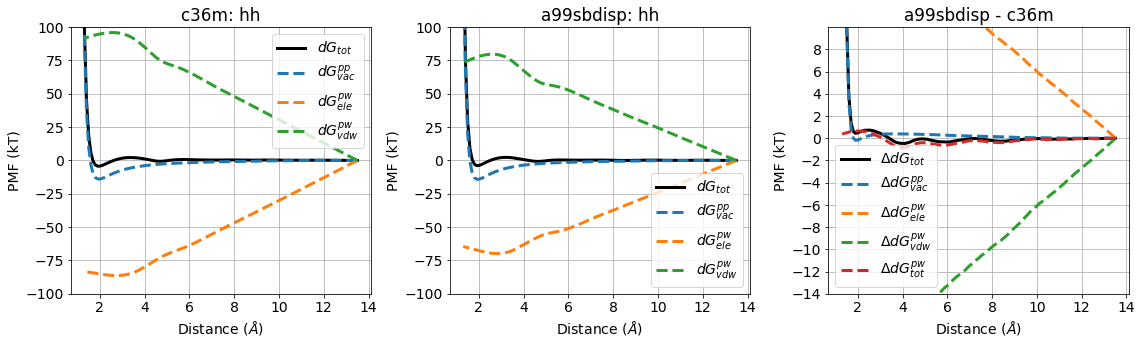

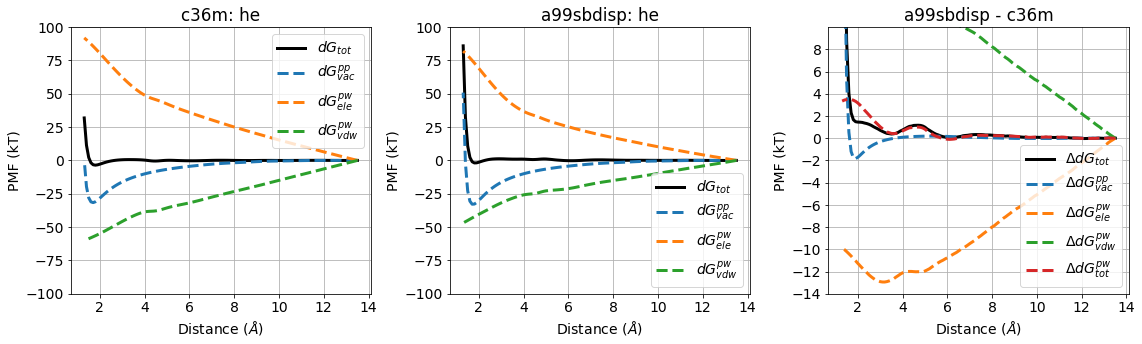

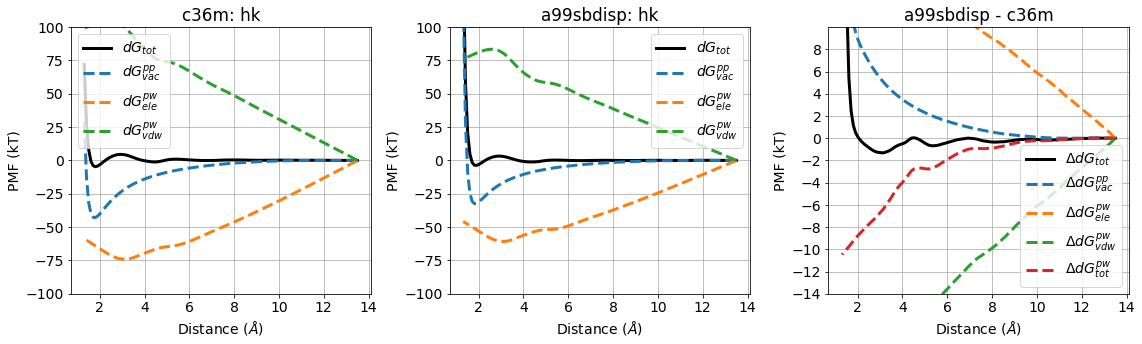

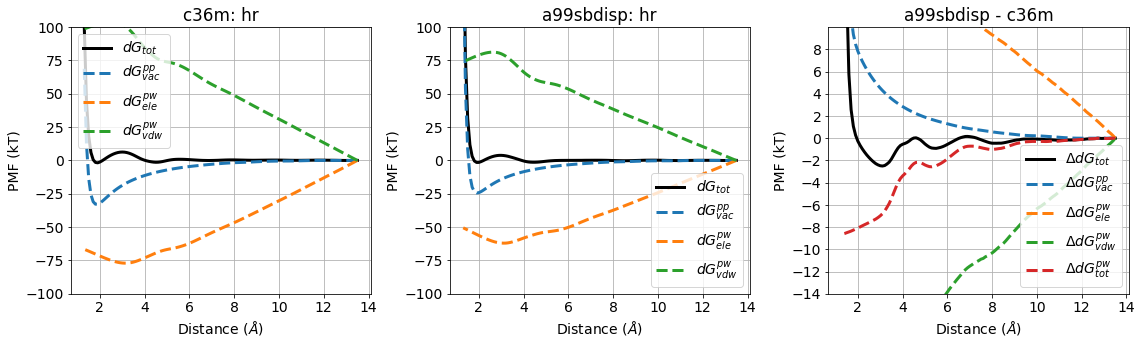

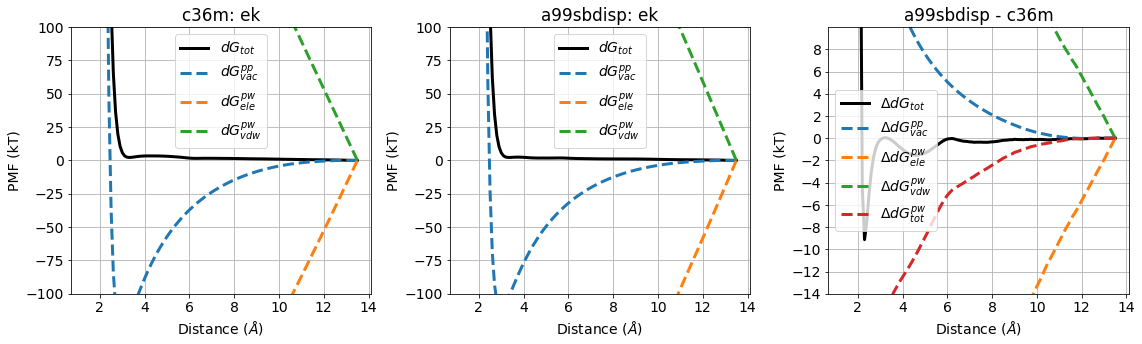

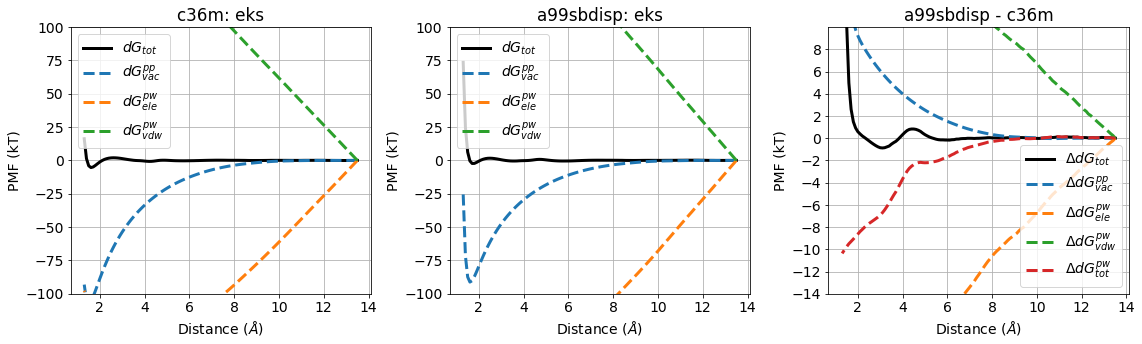

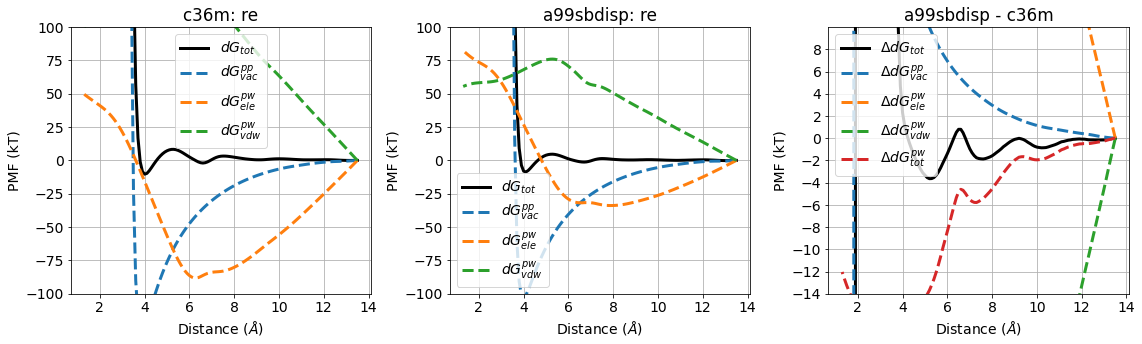

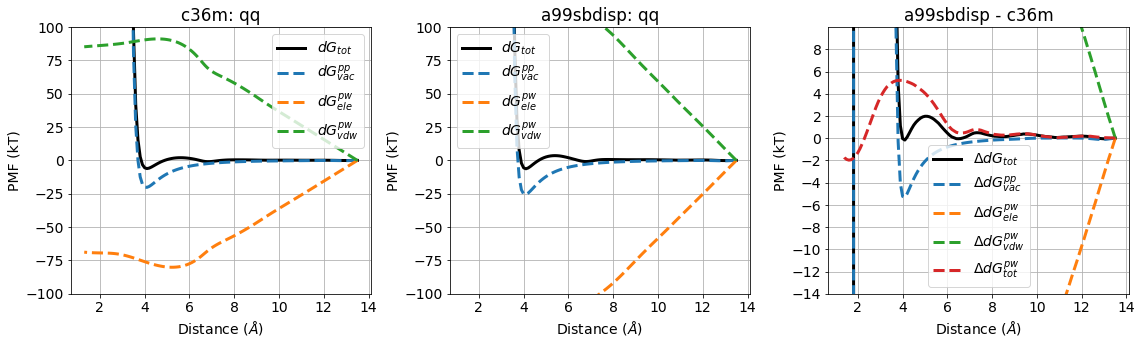

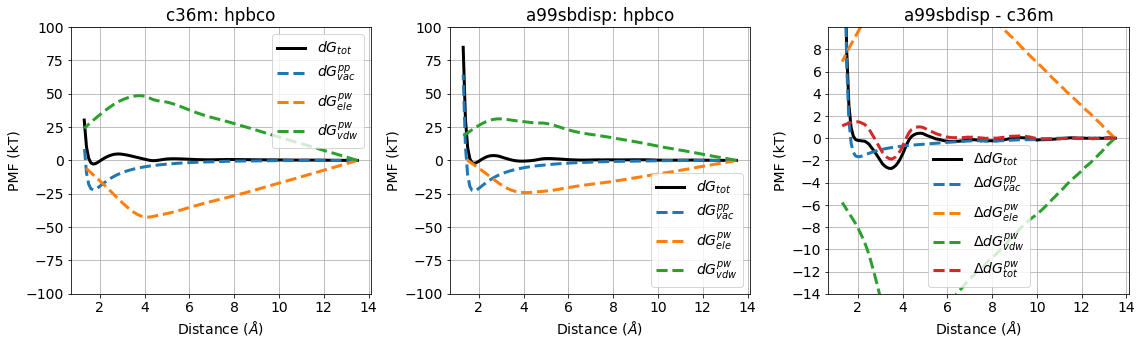

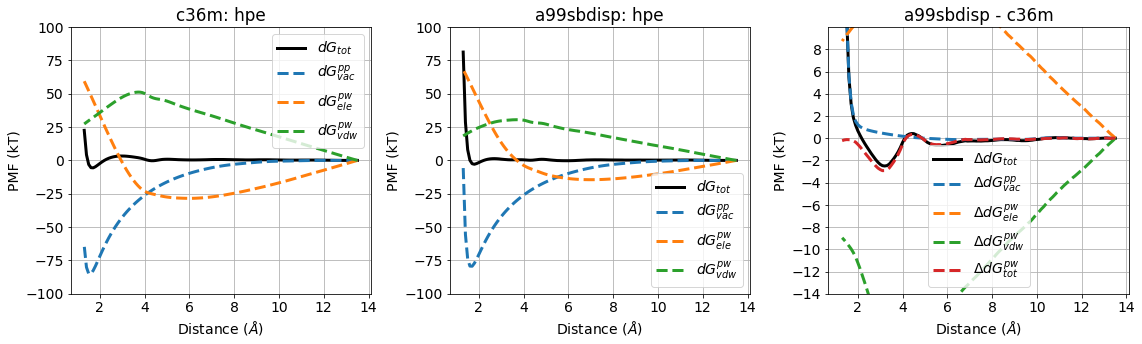

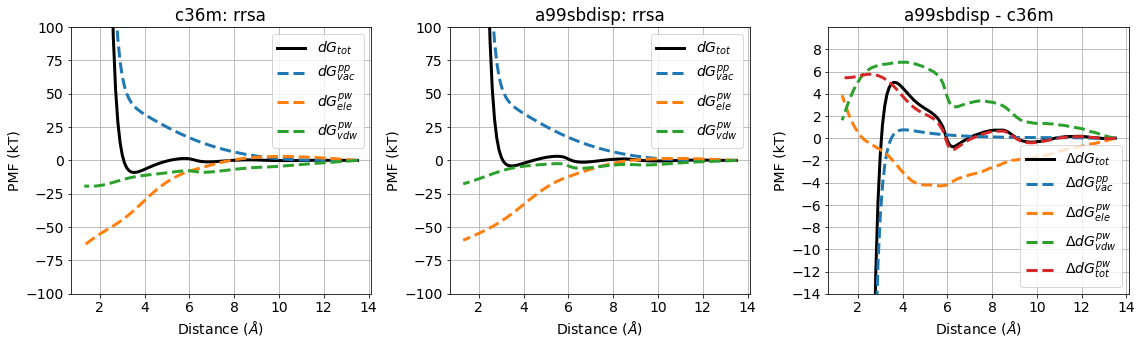

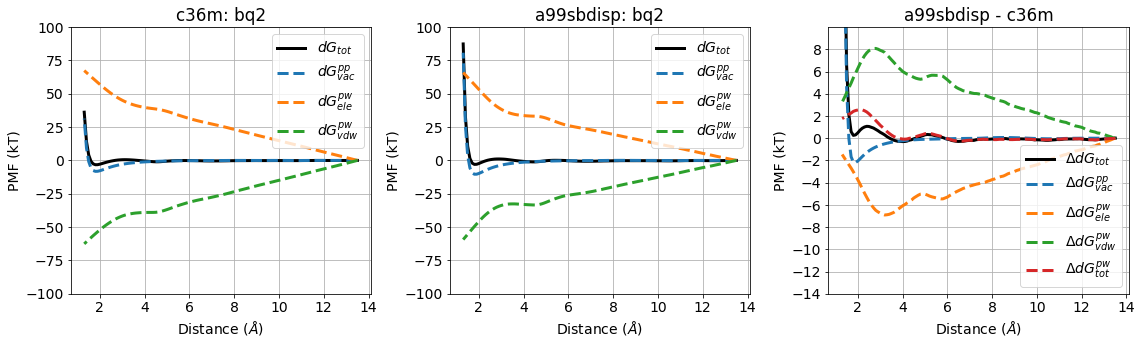

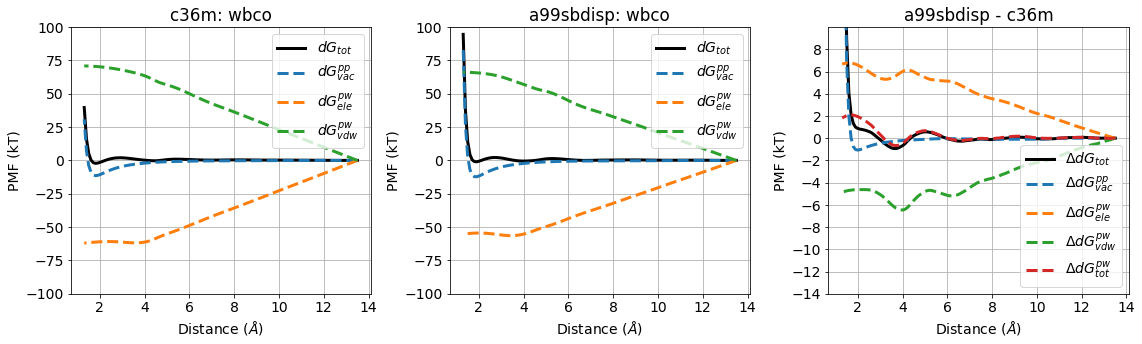

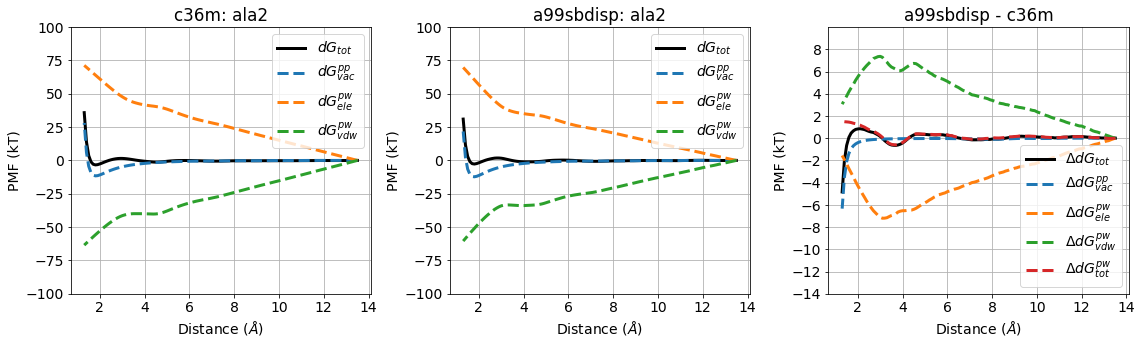

In [60]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.figsize'] = [16, 5]
plt.rcParams.update({'figure.max_open_warning': 0})

wdir='/home/ping/tutorial/fep/'
pdbids=['ww_p','ww_pd','ww_ap','ww_apd','ww_etf','ww_etf2','wf_etf','wf_p','wf_pd',
        'wy_etf','wy_pd','wp_p','wp_pd','wp_pda','ff_etf','ff_ap','ff_apd','fa_pd',
        'fl_p','fl_pd','wl_pd','wl_pd2','wl_pd3','wa_pd','aa_h','la_s','la_h','ll_p',
        'bk','br','hb','hbco','hh','he','hk','hr','ek','eks','re','qq','hpbco',
          'hpe','rrsa','bq2','wbco','ala2',
       ]
print('len(pdbids) = ', len(pdbids))

k = 0
for pdbid in pdbids:
    print(">> "+wdir+pdbid)
    
    k = k+1
    plt.figure(k)

    # c36m
    c36m = np.loadtxt(wdir+pdbid+'/chm36m/'+pdbid+'.chm36m.Gong2022.pmf')
    dat = np.copy(c36m)
    plt.subplot(1,3,1)
    plt.plot(dat[:,0], dat[:,1], 'k-', label='$dG_{tot}$')
    plt.plot(dat[:,0], dat[:,3], '--', label='$dG_{vac}^{pp}$')
    plt.plot(dat[:,0], dat[:,9], '--', label='$dG_{ele}^{pw}$')
    plt.plot(dat[:,0], dat[:,11], '--', label='$dG_{vdw}^{pw}$')
    plt.ylim([-100, 100])
    plt.legend()
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('PMF (kT)')
    plt.grid()
    #x=plt.yticks(np.arange(-14,10,2))
    plt.title('c36m: '+pdbid)
    
    # a99sbdisp
    a99 = np.loadtxt(wdir+pdbid+'/a99sbdisp/'+pdbid+'.a99sbdisp.Gong2022.pmf')
    dat = np.copy(a99)
    plt.subplot(1,3,2)
    plt.plot(dat[:,0], dat[:,1], 'k-', label='$dG_{tot}$')
    plt.plot(dat[:,0], dat[:,3], '--', label='$dG_{vac}^{pp}$')
    plt.plot(dat[:,0], dat[:,9], '--', label='$dG_{ele}^{pw}$')
    plt.plot(dat[:,0], dat[:,11], '--', label='$dG_{vdw}^{pw}$')
    plt.ylim([-100, 100])
    plt.legend()
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('PMF (kT)')
    plt.grid()
    #x=plt.yticks(np.arange(-14,10,2))
    plt.title('a99sbdisp: '+pdbid)
    
    # c36m - a99sbdisp
    dat[:,1:] = -c36m[:,1:] + a99[:,1:]
    plt.subplot(1,3,3)
    plt.plot(dat[:,0], dat[:,1], 'k-', label='$\Delta dG_{tot}$')
    plt.plot(dat[:,0], dat[:,3], '--', label='$\Delta dG_{vac}^{pp}$')
    plt.plot(dat[:,0], dat[:,9], '--', label='$\Delta dG_{ele}^{pw}$')
    plt.plot(dat[:,0], dat[:,11], '--', label='$\Delta dG_{vdw}^{pw}$')
    plt.plot(dat[:,0], dat[:,9]+dat[:,11], '--', label='$\Delta dG_{tot}^{pw}$')
    ylim = [-14, 10]
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('PMF (kT)')
    plt.grid()
    x=plt.yticks(np.arange(ylim[0],ylim[1],2))
    plt.title('a99sbdisp - c36m')
        
    plt.tight_layout()

# Appendix

## Free energies by MBAR reweighting

**Methology**

We have finished all MD simulations and obtained these trajectories in the data folder.
The next thing is that we can use them to calculate any properties of interest. 
Before calculating the properties, we have to generate the enough samples that
follow specific probability distribution.

As we know, any property can be calculated from the following equation,

$<A>_P = \int A(x)P(x)dx$,

where the $A(x)$ is the property to calculate, and $P(x)$ is our target probability distribution.
So, the next question is how we can generate the samples that follow the target $P(x)$. 
One important strategy is using a reweighting strategy that combines these two neighbor states.
For example, we can collect the trajectory samples from two dcd files (state 1: ala2.solv.d12.0.dcd 
and state 2: ala2.solv.d11.9.dcd),
which were sampled in two simulations in which the distances are 1.20 and 1.19 nm, respectively.
Then, we can construct a mixture distribution distribution that they follow,

$P_{mix}(x) = \sum_{k=1}^K{c_k * e^{F_k - f_k(x)}}$,

$c_k = \frac{n_k}{\sum_k{n_k}} = \frac{n_k}{N}$,

where $K$ is 2, $F_k$ is the relative free energy at $k^{th}$ state, and $f_k(x) = \beta_k E_k(x)$
this mixture probability can be used to describe the chosen samples.
In this way, given all samples, we should know how to calcualte this mixture probability, and 
all properties can be calculated from this mixture probability.

Then the Eq. (1) can be further derived as follows,

$<A>_P = \int{A(x)P(x)}dx = \int{A(x)\frac{P(x)}{P_{mix}(x)} P_{mix}(x)}dx$

$= \sum_{n=1}^{N} A(x_n) w(x_n), x_n \in P_{mix}(x)$,

where $ w(x_n) = \frac{1}{N} \sum_{n=1}^{N} \frac{P(x_n)}{P_{mix}(x_n)} $ and it subjects to $\sum_{n} w(x_n) = 1$.

**Relative free energies**

The relative free energies, $F_k$, can be further written as follows,

${F_k} = -log \int e^{-f_k(x)}dx$
$=-log \sum_n \frac{e^{-f_k(x_n)}}{\sum_{k=1}^K{n_k * e^{F_k - f_k(x_n)}}}, k=1,2$.

Here, the pymbar and FastMBAR packages can be used to calculate the relative $F_k$, given two neighbor states.
In this way, we can do a cumulative sum of their relative free energy difference between any two neighbor states,
then, the free energy of the $n^{th}$ state can be written as below, which are based on the first state.

$F_{n0} = \sum_{k=1}^n (F_{k} - F_{k-1})$.

In this way, we can make the following equation alway be correct by combining all samples of both states,

$F_{AB} + F_{BA} = 0$.

**Reference**

[1]. pymbar installation: https://github.com/choderalab/pymbar

[2]. FastMBAR installation: https://github.com/xqding/FastMBAR




## A simple approximation of free energy differenece without MBAR or BAR iterations

We assume that two states ($a$ and $b$) are sufficiently overlap, then a first-order approximation can be applied in both $f_{ac}$ and $f_{bc}$ along an order parameter ($\xi$).

$f_{ac}(x) = f_a(x) - f_c(x) \approx \frac{\delta f}{\delta \xi}(x)|_{\xi \rightarrow \xi_c} \xi_{ac} = g_c(x) \xi_{ac}$,

$f_{bc}(x) = f_b(x) - f_c(x) \approx \frac{\delta f}{\delta \xi}(x)|_{\xi \rightarrow \xi_c} \xi_{bc} = g_c(x) \xi_{bc}$,

When we have $|\xi_{ac}| = |\xi_{bc}|$, then we have,

$<\delta^2 f_{ac}(x)>_c = (\xi_{ac})^2<\delta^2 g_c(x)>_c$

$= (\xi_{bc})^2<\delta^2 g_c(x)>_c = <\delta^2 f_{bc}(x)>_c$,

To calculate the reduced free energy, $F_{ab}$, we expand these two states at an intermediate states $c$, 

$F_{ac} = -log<e^{-f_{ac}(x)}>_c \approx <f_{ac}(x)>_c - \frac{1}{2}<\delta^2 f_{ac}(x)>_c$, and

$F_{bc} = -log<e^{-f_{bc}(x)}>_c \approx <f_{bc}(x)>_c - \frac{1}{2}<\delta^2 f_{bc}(x)>_c$.

Then, we have the following estimator of the $F_{ab}$, by using a second order cumulant expansion,

$F_{ab} = F_{ac} - F_{bc} \approx <f_{ab}(x)> = \frac{1}{N}\sum_{n=1}^{N} f_{ab}(x_n), x_n \in states \{c\}$. 

The variance of this estimator can be written as,

$Var[F_{ab}] = \frac{1}{N^2}\sum_{n=1}^{N}Var[f_{ab}(x_n)] + 2\sum_{1<n \le N}\sum_{n<m \le N} Cov[f_{ab}(x_n), f_{ab}(x_m)]$.

This approximation allows us to calcualte the $F_{ab}$ by only one intermediate simulation at $\xi_c = \frac{1}{2}(\xi_a + \xi_b)$.